In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100.0
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [5]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Classification Generator 

In [7]:
class RandomBalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen=ImageDataGenerator(), batch_size=1):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        self._shape = x.shape   
        
        self.datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), 
            y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )
        
    def __len__(self):
        return self.steps_per_epoch   
    
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


class DeterministicBalancedGenerator(Sequence):
    def __init__(self, balanced_gen):
        self.x_gen = []
        self.y_gen = []
        self.steps_per_epoch = balanced_gen.steps_per_epoch
        
        for i in range(balanced_gen.steps_per_epoch):
            x, y = balanced_gen.__getitem__(None)
            self.x_gen.append(x)
            self.y_gen.append(y)
        
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        return self.x_gen[idx], self.y_gen[idx]

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [9]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = Dropout(rate=0.5)(base_model.get_layer(output_name).output)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [10]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=train_gen.steps_per_epoch,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [11]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, train_data, valid_data, train_gen, valid_gen, name):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    
    valid_bal = RandomBalancedDataGenerator(x_valid, y_valid, valid_gen, BATCH_SIZE)
    train_gen_bal = RandomBalancedDataGenerator(x_train, y_train, train_gen, BATCH_SIZE)
    valid_gen_bal = DeterministicBalancedGenerator(valid_bal)
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, train_gen_bal, valid_gen_bal, name)

    x_gen = valid_gen.flow(x_valid, batch_size=len(y_valid), shuffle=False).next()
    y_pred = model_classification.predict(x_gen).flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_valid, y_pred)
    
    return file_model

# Requirements Training 

In [12]:
list_model_files = []

#### 2. Blurred

71 of 71
48 of 48
(94, 160, 160, 3) float32
(94,) int32
(25, 160, 160, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 18s 182ms/step - loss: 90.1042 - val_loss: 75.8643
Epoch 2/100
100/100 [==============================] - 16s 158ms/step - loss: 75.7938 - val_loss: 72.1056
Epoch 3/100
100/100 [==============================] - 16s 158ms/step - loss: 68.1975 - val_loss: 70.5482
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 61.6060 - val_loss: 72.3697
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 54.6971 - val_loss: 73.4869
Epoch 6/100
100/100 [==============================] - 16s 157ms/step - loss: 48.1225 - val_loss: 72.7140
Epoch 7/100
100/100 [==============================] - 16s 158ms/step - loss: 44.0021 - val_loss: 75.6666
Epoch 8/100
100/100 [==============================] - 16s 157ms/step - loss: 38.3394 - val_loss: 76.4686
Epoch 9/100
100/100 [==============================] - 16s 158ms/step - loss: 35.1563 - val_loss: 76.348

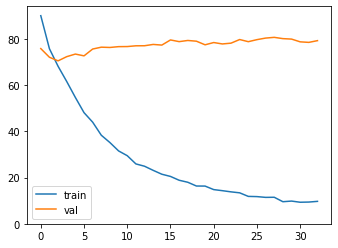

In [13]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 433ms/step - loss: 0.8571 - accuracy: 0.4792 - precision: 0.4338 - recall: 0.3135 - f1: 0.3549 - specificity: 0.6304 - negative_predictive_value: 0.5182 - matthews_correlation_coefficient: -0.0523 - equal_error_rate: 0.5526 - val_loss: 0.6971 - val_accuracy: 0.5600 - val_precision: 1.0000 - val_recall: 0.2667 - val_f1: 0.4211 - val_specificity: 1.0000 - val_negative_predictive_value: 0.4762 - val_matthews_correlation_coefficient: 0.3563 - val_equal_error_rate: 0.4333

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35635, saving model to ../../models/siamese_networks/blurred_2020_06_05-22_35_23.h5
Epoch 2/100
3/3 [==============================] - 1s 226ms/step - loss: 0.7700 - accuracy: 0.5250 - precision: 0.5772 - recall: 0.5648 - f1: 0.5633 - specificity: 0.4762 - negative_predictive_value: 0.4574 - matthews_correlation_coefficient: 0.0376 - equal_error_rate: 0.4603 - val_loss: 0.6950 - val_accuracy: 0.5

3/3 [==============================] - 0s 143ms/step - loss: 0.7713 - accuracy: 0.5375 - precision: 0.5741 - recall: 0.3889 - f1: 0.4635 - specificity: 0.6452 - negative_predictive_value: 0.4551 - matthews_correlation_coefficient: 0.0318 - equal_error_rate: 0.4726 - val_loss: 0.6943 - val_accuracy: 0.6800 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9000 - val_negative_predictive_value: 0.5625 - val_matthews_correlation_coefficient: 0.4423 - val_equal_error_rate: 0.4333

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.50918
Epoch 15/100
3/3 [==============================] - 0s 141ms/step - loss: 0.7463 - accuracy: 0.5750 - precision: 0.5890 - recall: 0.5040 - f1: 0.5410 - specificity: 0.6704 - negative_predictive_value: 0.5525 - matthews_correlation_coefficient: 0.1568 - equal_error_rate: 0.4130 - val_loss: 0.6946 - val_accuracy: 0.6800 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.50918
Epoch 28/100
3/3 [==============================] - 0s 135ms/step - loss: 0.7343 - accuracy: 0.5375 - precision: 0.6818 - recall: 0.4392 - f1: 0.5281 - specificity: 0.7407 - negative_predictive_value: 0.4693 - matthews_correlation_coefficient: 0.1645 - equal_error_rate: 0.4094 - val_loss: 0.6995 - val_accuracy: 0.6800 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9000 - val_negative_predictive_value: 0.5625 - val_matthews_correlation_coefficient: 0.4423 - val_equal_error_rate: 0.4333

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.50918
Epoch 29/100
3/3 [==============================] - 0s 136ms/step - loss: 0.7690 - accuracy: 0.6042 - precision: 0.5694 - recall: 0.5066 - f1: 0.5293 - specificity: 0.6865 - negative_predictive_value: 0.6273 - matthews_correlation_coefficient: 0.1949 - equal_error_rate: 0.4411 - val_loss: 0.6987 - val_accuracy: 0

3/3 [==============================] - 0s 146ms/step - loss: 0.7649 - accuracy: 0.4688 - precision: 0.3977 - recall: 0.3598 - f1: 0.3746 - specificity: 0.5265 - negative_predictive_value: 0.4918 - matthews_correlation_coefficient: -0.1122 - equal_error_rate: 0.5012 - val_loss: 0.6982 - val_accuracy: 0.6800 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9000 - val_negative_predictive_value: 0.5625 - val_matthews_correlation_coefficient: 0.4423 - val_equal_error_rate: 0.4333

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.50918
Epoch 42/100
3/3 [==============================] - 0s 145ms/step - loss: 0.7755 - accuracy: 0.5500 - precision: 0.6524 - recall: 0.4630 - f1: 0.5315 - specificity: 0.6857 - negative_predictive_value: 0.4876 - matthews_correlation_coefficient: 0.1436 - equal_error_rate: 0.4382 - val_loss: 0.6989 - val_accuracy: 0.6800 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.900


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.50918
Epoch 55/100
3/3 [==============================] - 0s 143ms/step - loss: 0.7711 - accuracy: 0.5750 - precision: 0.5774 - recall: 0.5476 - f1: 0.5546 - specificity: 0.5667 - negative_predictive_value: 0.5317 - matthews_correlation_coefficient: 0.1115 - equal_error_rate: 0.4279 - val_loss: 0.6996 - val_accuracy: 0.6800 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9000 - val_negative_predictive_value: 0.5625 - val_matthews_correlation_coefficient: 0.4423 - val_equal_error_rate: 0.4333
Restoring model weights from the end of the best epoch

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.50918
Epoch 00055: early stopping

   Final Accuracy:  64.00%
  Final Precision:  87.50%
     Final Recall:  46.67%
  Final F-measure:  60.87%
Final Specificity:  90.00%
        Final NPV:  52.94%
        Final MCC:  38.51%

[[9 1]
 [8 7]]
              precision  

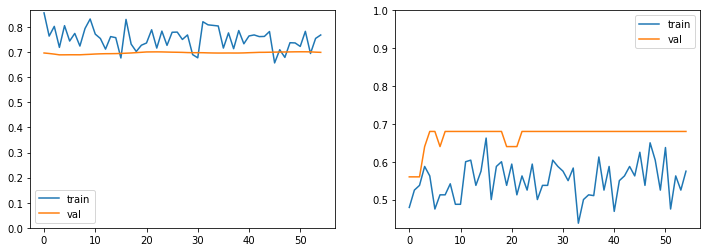

In [14]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 160, 160, 3) float32
(243,) int32
(62, 160, 160, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 243ms/step - loss: 97.7406 - val_loss: 99.8998
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 93.3062 - val_loss: 99.4258
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 87.6379 - val_loss: 99.2410
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 84.3900 - val_loss: 99.7781
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 81.6639 - val_loss: 99.5755
Epoch 6/100
100/100 [==============================] - 23s 231ms/step - loss: 80.6826 - val_loss: 98.5435
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 75.5759 - val_loss: 98.9371
Epoch 8/100
100/100 [==============================] - 23s 230ms/step - loss: 74.5743 - val_loss: 97.0311
Epoch 9/100
100/100 [==============================] - 23s 230ms/step - loss: 72.7061 - val_loss: 99.3736
Epoch 10/100
100/100 [========================

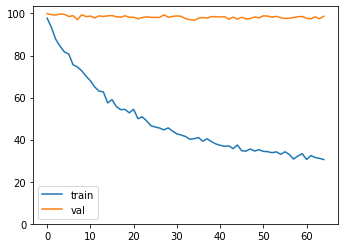

In [15]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 267ms/step - loss: 0.9390 - accuracy: 0.4866 - precision: 0.4948 - recall: 0.4796 - f1: 0.4828 - specificity: 0.4935 - negative_predictive_value: 0.4770 - matthews_correlation_coefficient: -0.0276 - equal_error_rate: 0.5081 - val_loss: 0.7200 - val_accuracy: 0.5469 - val_precision: 0.5333 - val_recall: 0.5466 - val_f1: 0.5386 - val_specificity: 0.5324 - val_negative_predictive_value: 0.5441 - val_matthews_correlation_coefficient: 0.0782 - val_equal_error_rate: 0.5000

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07820, saving model to ../../models/siamese_networks/looking_away_2020_06_05-23_01_19.h5
Epoch 2/100
7/7 [==============================] - 1s 148ms/step - loss: 0.8381 - accuracy: 0.5811 - precision: 0.6081 - recall: 0.5188 - f1: 0.5566 - specificity: 0.6432 - negative_predictive_value: 0.5592 - matthews_correlation_coefficient: 0.1646 - equal_error_rate: 0.4450 - val_loss: 0.7340 - val_accuracy

7/7 [==============================] - 1s 137ms/step - loss: 0.7088 - accuracy: 0.6532 - precision: 0.6841 - recall: 0.5451 - f1: 0.5971 - specificity: 0.7651 - negative_predictive_value: 0.6413 - matthews_correlation_coefficient: 0.3174 - equal_error_rate: 0.3691 - val_loss: 0.7885 - val_accuracy: 0.5156 - val_precision: 0.5357 - val_recall: 0.1822 - val_f1: 0.2715 - val_specificity: 0.8320 - val_negative_predictive_value: 0.5036 - val_matthews_correlation_coefficient: 0.0240 - val_equal_error_rate: 0.5000

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.07820
Epoch 15/100
7/7 [==============================] - 1s 137ms/step - loss: 0.8091 - accuracy: 0.5631 - precision: 0.5732 - recall: 0.4838 - f1: 0.5226 - specificity: 0.6413 - negative_predictive_value: 0.5554 - matthews_correlation_coefficient: 0.1268 - equal_error_rate: 0.4186 - val_loss: 0.7976 - val_accuracy: 0.5312 - val_precision: 0.5833 - val_recall: 0.1822 - val_f1: 0.2776 - val_specificity: 0.8704

7/7 [==============================] - 1s 132ms/step - loss: 0.7212 - accuracy: 0.6081 - precision: 0.6532 - recall: 0.4037 - f1: 0.4921 - specificity: 0.8064 - negative_predictive_value: 0.5951 - matthews_correlation_coefficient: 0.2280 - equal_error_rate: 0.4187 - val_loss: 0.7687 - val_accuracy: 0.5312 - val_precision: 0.5238 - val_recall: 0.1700 - val_f1: 0.2548 - val_specificity: 0.8704 - val_negative_predictive_value: 0.5131 - val_matthews_correlation_coefficient: 0.0411 - val_equal_error_rate: 0.5000

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.10101
Epoch 28/100
7/7 [==============================] - 1s 131ms/step - loss: 0.7522 - accuracy: 0.5901 - precision: 0.6605 - recall: 0.4254 - f1: 0.5004 - specificity: 0.7680 - negative_predictive_value: 0.5716 - matthews_correlation_coefficient: 0.2106 - equal_error_rate: 0.4160 - val_loss: 0.7587 - val_accuracy: 0.5312 - val_precision: 0.5625 - val_recall: 0.2085 - val_f1: 0.3028 - val_specificity: 0.8320


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.10101
Epoch 41/100
7/7 [==============================] - 1s 138ms/step - loss: 0.7426 - accuracy: 0.5446 - precision: 0.5766 - recall: 0.4334 - f1: 0.4905 - specificity: 0.6531 - negative_predictive_value: 0.5255 - matthews_correlation_coefficient: 0.0938 - equal_error_rate: 0.4458 - val_loss: 0.7488 - val_accuracy: 0.5156 - val_precision: 0.5125 - val_recall: 0.2085 - val_f1: 0.2963 - val_specificity: 0.8057 - val_negative_predictive_value: 0.5046 - val_matthews_correlation_coefficient: 0.0156 - val_equal_error_rate: 0.5000

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.10101
Epoch 42/100
7/7 [==============================] - 1s 136ms/step - loss: 0.7059 - accuracy: 0.5856 - precision: 0.6469 - recall: 0.4631 - f1: 0.5300 - specificity: 0.7249 - negative_predictive_value: 0.5648 - matthews_correlation_coefficient: 0.1994 - equal_error_rate: 0.4274 - val_loss: 0.7623 - val_accuracy: 0

7/7 [==============================] - 1s 133ms/step - loss: 0.7143 - accuracy: 0.5991 - precision: 0.6500 - recall: 0.3728 - f1: 0.4661 - specificity: 0.8210 - negative_predictive_value: 0.5792 - matthews_correlation_coefficient: 0.2105 - equal_error_rate: 0.4083 - val_loss: 0.7454 - val_accuracy: 0.5000 - val_precision: 0.4857 - val_recall: 0.1822 - val_f1: 0.2650 - val_specificity: 0.8057 - val_negative_predictive_value: 0.4963 - val_matthews_correlation_coefficient: -0.0148 - val_equal_error_rate: 0.5000

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.10101
Epoch 55/100
7/7 [==============================] - 1s 138ms/step - loss: 0.7553 - accuracy: 0.5676 - precision: 0.5963 - recall: 0.4460 - f1: 0.5008 - specificity: 0.7017 - negative_predictive_value: 0.5589 - matthews_correlation_coefficient: 0.1514 - equal_error_rate: 0.4394 - val_loss: 0.7457 - val_accuracy: 0.5000 - val_precision: 0.4857 - val_recall: 0.1822 - val_f1: 0.2650 - val_specificity: 0.805

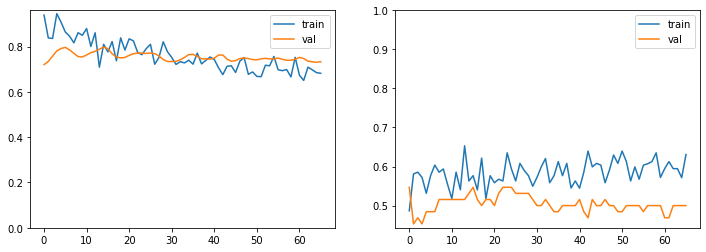

In [16]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 160, 160, 3) float32
(90,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 174ms/step - loss: 88.3810 - val_loss: 134.3129
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 65.0498 - val_loss: 160.5224
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 49.5613 - val_loss: 168.3147
Epoch 4/100
100/100 [==============================] - 16s 162ms/step - loss: 38.1423 - val_loss: 170.4822
Epoch 5/100
100/100 [==============================] - 16s 162ms/step - loss: 28.9280 - val_loss: 174.0206
Epoch 6/100
100/100 [==============================] - 16s 163ms/step - loss: 22.6614 - val_loss: 173.0732
Epoch 7/100
100/100 [==============================] - 16s 162ms/step - loss: 17.0029 - val_loss: 171.2204
Epoch 8/100
100/100 [==============================] - 16s 162ms/step - loss: 15.4401 - val_loss: 168.7215
Epoch 9/100
100/100 [==============================] - 16s 162ms/step - loss: 12.1518 - val_loss: 167.4627
Epoch 10/100
100/100 [===============

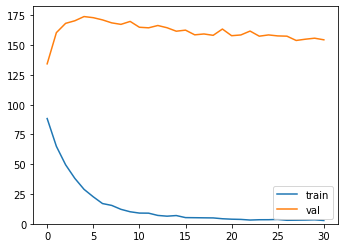

In [17]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 507ms/step - loss: 0.8345 - accuracy: 0.6146 - precision: 0.7250 - recall: 0.3889 - f1: 0.5039 - specificity: 0.8519 - negative_predictive_value: 0.5732 - matthews_correlation_coefficient: 0.2678 - equal_error_rate: 0.4676 - val_loss: 1.3178 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.4615 - val_f1: 0.4286 - val_specificity: 0.1818 - val_negative_predictive_value: 0.2222 - val_matthews_correlation_coefficient: -0.3671 - val_equal_error_rate: 0.6189

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.36706, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_05-23_11_12.h5
Epoch 2/100
3/3 [==============================] - 1s 195ms/step - loss: 0.8444 - accuracy: 0.6471 - precision: 0.4762 - recall: 0.3194 - f1: 0.3737 - specificity: 0.7663 - negative_predictive_value: 0.6444 - matthews_correlation_coefficient: 0.1017 - equal_error_rate: 0.4761 - val_loss: 1.2485 - val_

3/3 [==============================] - 0s 136ms/step - loss: 0.6483 - accuracy: 0.5588 - precision: 0.3683 - recall: 0.3444 - f1: 0.3556 - specificity: 0.6266 - negative_predictive_value: 0.6035 - matthews_correlation_coefficient: -0.0286 - equal_error_rate: 0.5040 - val_loss: 0.7408 - val_accuracy: 0.4583 - val_precision: 0.5000 - val_recall: 0.5385 - val_f1: 0.5185 - val_specificity: 0.3636 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.0989 - val_equal_error_rate: 0.6643

Epoch 00014: val_matthews_correlation_coefficient improved from -0.26857 to -0.09895, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_05-23_11_12.h5
Epoch 15/100
3/3 [==============================] - 0s 155ms/step - loss: 0.6582 - accuracy: 0.6176 - precision: 0.6313 - recall: 0.6148 - f1: 0.5728 - specificity: 0.7586 - negative_predictive_value: 0.7108 - matthews_correlation_coefficient: 0.3553 - equal_error_rate: 0.4377 - val_loss: 0.7285 - val_accura


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.40629
Epoch 27/100
3/3 [==============================] - 0s 148ms/step - loss: 0.6896 - accuracy: 0.6176 - precision: 0.5876 - recall: 0.7370 - f1: 0.6319 - specificity: 0.6368 - negative_predictive_value: 0.7294 - matthews_correlation_coefficient: 0.3434 - equal_error_rate: 0.4718 - val_loss: 0.6874 - val_accuracy: 0.5833 - val_precision: 0.7143 - val_recall: 0.3846 - val_f1: 0.5000 - val_specificity: 0.8182 - val_negative_predictive_value: 0.5294 - val_matthews_correlation_coefficient: 0.2223 - val_equal_error_rate: 0.4580

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.40629
Epoch 28/100
3/3 [==============================] - 0s 143ms/step - loss: 0.6157 - accuracy: 0.6471 - precision: 0.6627 - recall: 0.7060 - f1: 0.6435 - specificity: 0.7014 - negative_predictive_value: 0.7162 - matthews_correlation_coefficient: 0.3906 - equal_error_rate: 0.4572 - val_loss: 0.6868 - val_accuracy: 0

3/3 [==============================] - 0s 148ms/step - loss: 0.5646 - accuracy: 0.6765 - precision: 0.8000 - recall: 0.7454 - f1: 0.7706 - specificity: 0.8006 - negative_predictive_value: 0.7451 - matthews_correlation_coefficient: 0.5455 - equal_error_rate: 0.4056 - val_loss: 0.6911 - val_accuracy: 0.6250 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9091 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.3380 - val_equal_error_rate: 0.4580

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.40629
Epoch 41/100
3/3 [==============================] - 0s 141ms/step - loss: 0.6521 - accuracy: 0.6146 - precision: 0.6719 - recall: 0.4903 - f1: 0.5660 - specificity: 0.7447 - negative_predictive_value: 0.5810 - matthews_correlation_coefficient: 0.2438 - equal_error_rate: 0.3641 - val_loss: 0.6903 - val_accuracy: 0.6250 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9091


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.40629
Epoch 54/100
3/3 [==============================] - 0s 137ms/step - loss: 0.6867 - accuracy: 0.7206 - precision: 0.6022 - recall: 0.8069 - f1: 0.6477 - specificity: 0.6172 - negative_predictive_value: 0.8241 - matthews_correlation_coefficient: 0.4252 - equal_error_rate: 0.4663 - val_loss: 0.6765 - val_accuracy: 0.6250 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9091 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.3380 - val_equal_error_rate: 0.2902

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.40629
Epoch 55/100
3/3 [==============================] - 0s 148ms/step - loss: 0.5349 - accuracy: 0.7059 - precision: 0.8333 - recall: 0.7407 - f1: 0.7823 - specificity: 0.8417 - negative_predictive_value: 0.7598 - matthews_correlation_coefficient: 0.5877 - equal_error_rate: 0.3747 - val_loss: 0.6760 - val_accuracy: 0

3/3 [==============================] - 0s 144ms/step - loss: 0.5728 - accuracy: 0.6324 - precision: 0.7879 - recall: 0.6407 - f1: 0.6994 - specificity: 0.8459 - negative_predictive_value: 0.7143 - matthews_correlation_coefficient: 0.4942 - equal_error_rate: 0.4374 - val_loss: 0.6826 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.3846 - val_f1: 0.5556 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.4719 - val_equal_error_rate: 0.3287

Epoch 00067: val_matthews_correlation_coefficient improved from 0.40629 to 0.47188, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_05-23_11_12.h5
Epoch 68/100
3/3 [==============================] - 0s 156ms/step - loss: 0.5538 - accuracy: 0.6176 - precision: 0.6111 - recall: 0.6852 - f1: 0.6147 - specificity: 0.6865 - negative_predictive_value: 0.7098 - matthews_correlation_coefficient: 0.3443 - equal_error_rate: 0.3848 - val_loss: 0.6825 - val_accuracy: 

3/3 [==============================] - 0s 152ms/step - loss: 0.5729 - accuracy: 0.7353 - precision: 0.8444 - recall: 0.7847 - f1: 0.8123 - specificity: 0.8452 - negative_predictive_value: 0.7843 - matthews_correlation_coefficient: 0.6294 - equal_error_rate: 0.3332 - val_loss: 0.6759 - val_accuracy: 0.6250 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9091 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: 0.3380 - val_equal_error_rate: 0.2902

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.47188
Epoch 81/100
3/3 [==============================] - 0s 144ms/step - loss: 0.5865 - accuracy: 0.6667 - precision: 0.7070 - recall: 0.5949 - f1: 0.6451 - specificity: 0.7430 - negative_predictive_value: 0.6365 - matthews_correlation_coefficient: 0.3406 - equal_error_rate: 0.3435 - val_loss: 0.6761 - val_accuracy: 0.6250 - val_precision: 0.8333 - val_recall: 0.3846 - val_f1: 0.5263 - val_specificity: 0.9091


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.47188
Epoch 94/100
3/3 [==============================] - 0s 156ms/step - loss: 0.5671 - accuracy: 0.6912 - precision: 0.7614 - recall: 0.8097 - f1: 0.7818 - specificity: 0.7574 - negative_predictive_value: 0.8115 - matthews_correlation_coefficient: 0.5699 - equal_error_rate: 0.3648 - val_loss: 0.6739 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.3846 - val_f1: 0.5556 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.4719 - val_equal_error_rate: 0.2902

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.47188
Epoch 95/100
3/3 [==============================] - 0s 154ms/step - loss: 0.6232 - accuracy: 0.6765 - precision: 0.6667 - recall: 0.7000 - f1: 0.6444 - specificity: 0.7586 - negative_predictive_value: 0.7500 - matthews_correlation_coefficient: 0.4356 - equal_error_rate: 0.4165 - val_loss: 0.6738 - val_accuracy: 0

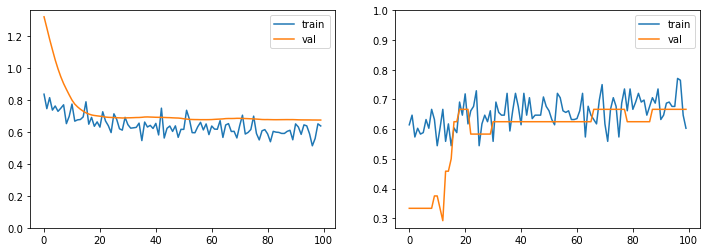

In [18]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 160, 160, 3) float32
(121,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 189ms/step - loss: 80.2432 - val_loss: 95.2492
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 61.0799 - val_loss: 96.8410
Epoch 3/100
100/100 [==============================] - 18s 177ms/step - loss: 45.7519 - val_loss: 93.1727
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 35.6247 - val_loss: 89.1840
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 27.6441 - val_loss: 87.3828
Epoch 6/100
100/100 [==============================] - 18s 177ms/step - loss: 21.4015 - val_loss: 86.4587
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 18.3845 - val_loss: 85.0642
Epoch 8/100
100/100 [==============================] - 18s 177ms/step - loss: 15.6036 - val_loss: 83.8226
Epoch 9/100
100/100 [==============================] - 18s 176ms/step - loss: 13.8559 - val_loss: 82.6835
Epoch 10/100
100/100 [========================

100/100 [==============================] - 18s 176ms/step - loss: 1.2420 - val_loss: 64.0661
Epoch 79/100
100/100 [==============================] - 18s 177ms/step - loss: 1.3353 - val_loss: 62.5968
Epoch 80/100
100/100 [==============================] - 18s 177ms/step - loss: 1.5761 - val_loss: 63.8434
Epoch 81/100
100/100 [==============================] - 18s 176ms/step - loss: 1.5732 - val_loss: 63.4912
Epoch 82/100
100/100 [==============================] - 18s 176ms/step - loss: 1.5533 - val_loss: 62.0667
Epoch 83/100
100/100 [==============================] - 18s 176ms/step - loss: 1.4747 - val_loss: 62.0179
Epoch 84/100
100/100 [==============================] - 18s 176ms/step - loss: 1.5041 - val_loss: 62.0031
Epoch 85/100
100/100 [==============================] - 18s 176ms/step - loss: 1.3175 - val_loss: 60.0170
Epoch 86/100
100/100 [==============================] - 18s 176ms/step - loss: 1.6616 - val_loss: 61.4688
Epoch 87/100
100/100 [==============================] - 18s

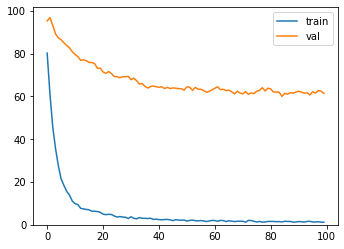

In [19]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 549ms/step - loss: 0.9919 - accuracy: 0.5000 - precision: 0.5205 - recall: 0.3278 - f1: 0.4001 - specificity: 0.6716 - negative_predictive_value: 0.4864 - matthews_correlation_coefficient: 0.0030 - equal_error_rate: 0.4997 - val_loss: 0.9446 - val_accuracy: 0.4516 - val_precision: 0.4286 - val_recall: 0.4000 - val_f1: 0.4138 - val_specificity: 0.5000 - val_negative_predictive_value: 0.4706 - val_matthews_correlation_coefficient: -0.1004 - val_equal_error_rate: 0.5813

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.10042, saving model to ../../models/siamese_networks/too_dark_light_2020_06_05-23_42_00.h5
Epoch 2/100
3/3 [==============================] - 1s 231ms/step - loss: 0.9425 - accuracy: 0.5326 - precision: 0.5231 - recall: 0.2956 - f1: 0.3770 - specificity: 0.7506 - negative_predictive_value: 0.5378 - matthews_correlation_coefficient: 0.0531 - equal_error_rate: 0.5230 - val_loss: 0.9060 - val_accur

3/3 [==============================] - 0s 136ms/step - loss: 0.5861 - accuracy: 0.7174 - precision: 0.8308 - recall: 0.5448 - f1: 0.6536 - specificity: 0.8775 - negative_predictive_value: 0.6759 - matthews_correlation_coefficient: 0.4619 - equal_error_rate: 0.3118 - val_loss: 0.7201 - val_accuracy: 0.6452 - val_precision: 0.8333 - val_recall: 0.3333 - val_f1: 0.4762 - val_specificity: 0.9375 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.3426 - val_equal_error_rate: 0.2583

Epoch 00014: val_matthews_correlation_coefficient improved from 0.27741 to 0.34258, saving model to ../../models/siamese_networks/too_dark_light_2020_06_05-23_42_00.h5
Epoch 15/100
3/3 [==============================] - 0s 126ms/step - loss: 0.6648 - accuracy: 0.7283 - precision: 0.8750 - recall: 0.5194 - f1: 0.6516 - specificity: 0.9333 - negative_predictive_value: 0.6541 - matthews_correlation_coefficient: 0.4892 - equal_error_rate: 0.2985 - val_loss: 0.7157 - val_accuracy: 0.709

3/3 [==============================] - 0s 99ms/step - loss: 0.6206 - accuracy: 0.7283 - precision: 0.9583 - recall: 0.5062 - f1: 0.6538 - specificity: 0.9792 - negative_predictive_value: 0.6582 - matthews_correlation_coefficient: 0.5463 - equal_error_rate: 0.2383 - val_loss: 0.6925 - val_accuracy: 0.7419 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9375 - val_negative_predictive_value: 0.6818 - val_matthews_correlation_coefficient: 0.5184 - val_equal_error_rate: 0.1625

Epoch 00027: val_matthews_correlation_coefficient improved from 0.46159 to 0.51837, saving model to ../../models/siamese_networks/too_dark_light_2020_06_05-23_42_00.h5
Epoch 28/100
3/3 [==============================] - 0s 114ms/step - loss: 0.6488 - accuracy: 0.7283 - precision: 0.8091 - recall: 0.6088 - f1: 0.6933 - specificity: 0.8517 - negative_predictive_value: 0.6842 - matthews_correlation_coefficient: 0.4765 - equal_error_rate: 0.2823 - val_loss: 0.6882 - val_accuracy: 0.7419

3/3 [==============================] - 0s 109ms/step - loss: 0.5368 - accuracy: 0.7717 - precision: 0.8561 - recall: 0.6601 - f1: 0.7419 - specificity: 0.8925 - negative_predictive_value: 0.7256 - matthews_correlation_coefficient: 0.5669 - equal_error_rate: 0.2280 - val_loss: 0.6790 - val_accuracy: 0.7419 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9375 - val_negative_predictive_value: 0.6818 - val_matthews_correlation_coefficient: 0.5184 - val_equal_error_rate: 0.1625

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.51837
Epoch 41/100
3/3 [==============================] - 0s 126ms/step - loss: 0.5728 - accuracy: 0.6979 - precision: 0.7908 - recall: 0.5741 - f1: 0.6583 - specificity: 0.8293 - negative_predictive_value: 0.6511 - matthews_correlation_coefficient: 0.4217 - equal_error_rate: 0.2386 - val_loss: 0.6781 - val_accuracy: 0.7419 - val_precision: 0.8889 - val_recall: 0.5333 - val_f1: 0.6667 - val_specificity: 0.9375

3/3 [==============================] - 0s 124ms/step - loss: 0.4269 - accuracy: 0.8125 - precision: 0.8984 - recall: 0.7116 - f1: 0.7904 - specificity: 0.9149 - negative_predictive_value: 0.7577 - matthews_correlation_coefficient: 0.6408 - equal_error_rate: 0.2082 - val_loss: 0.6802 - val_accuracy: 0.7742 - val_precision: 0.9000 - val_recall: 0.6000 - val_f1: 0.7200 - val_specificity: 0.9375 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5746 - val_equal_error_rate: 0.1937

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.57461
Epoch 54/100
3/3 [==============================] - 0s 108ms/step - loss: 0.5268 - accuracy: 0.7609 - precision: 0.8245 - recall: 0.6371 - f1: 0.7149 - specificity: 0.8733 - negative_predictive_value: 0.7257 - matthews_correlation_coefficient: 0.5297 - equal_error_rate: 0.2492 - val_loss: 0.6786 - val_accuracy: 0.7742 - val_precision: 0.9000 - val_recall: 0.6000 - val_f1: 0.7200 - val_specificity: 0.9375


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.57461
Epoch 67/100
3/3 [==============================] - 0s 120ms/step - loss: 0.4207 - accuracy: 0.8370 - precision: 0.9167 - recall: 0.7448 - f1: 0.8202 - specificity: 0.9347 - negative_predictive_value: 0.7801 - matthews_correlation_coefficient: 0.6880 - equal_error_rate: 0.1755 - val_loss: 0.6900 - val_accuracy: 0.7742 - val_precision: 0.9000 - val_recall: 0.6000 - val_f1: 0.7200 - val_specificity: 0.9375 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5746 - val_equal_error_rate: 0.1937

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.57461
Epoch 68/100
3/3 [==============================] - 0s 107ms/step - loss: 0.5366 - accuracy: 0.7500 - precision: 0.8077 - recall: 0.6530 - f1: 0.7203 - specificity: 0.8507 - negative_predictive_value: 0.7114 - matthews_correlation_coefficient: 0.5113 - equal_error_rate: 0.2280 - val_loss: 0.6926 - val_accuracy: 0

3/3 [==============================] - 0s 118ms/step - loss: 0.4397 - accuracy: 0.8261 - precision: 0.8915 - recall: 0.7274 - f1: 0.7983 - specificity: 0.9190 - negative_predictive_value: 0.7794 - matthews_correlation_coefficient: 0.6582 - equal_error_rate: 0.1861 - val_loss: 0.7006 - val_accuracy: 0.7742 - val_precision: 0.9000 - val_recall: 0.6000 - val_f1: 0.7200 - val_specificity: 0.9375 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5746 - val_equal_error_rate: 0.1937

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.57461
Epoch 81/100
3/3 [==============================] - 0s 119ms/step - loss: 0.3932 - accuracy: 0.8125 - precision: 0.8968 - recall: 0.7130 - f1: 0.7932 - specificity: 0.9191 - negative_predictive_value: 0.7549 - matthews_correlation_coefficient: 0.6418 - equal_error_rate: 0.1664 - val_loss: 0.7003 - val_accuracy: 0.7742 - val_precision: 0.9000 - val_recall: 0.6000 - val_f1: 0.7200 - val_specificity: 0.9375


Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.57461
Epoch 94/100
3/3 [==============================] - 0s 109ms/step - loss: 0.3783 - accuracy: 0.8478 - precision: 0.9667 - recall: 0.7002 - f1: 0.8039 - specificity: 0.9778 - negative_predictive_value: 0.7917 - matthews_correlation_coefficient: 0.7159 - equal_error_rate: 0.1658 - val_loss: 0.6965 - val_accuracy: 0.7742 - val_precision: 0.9000 - val_recall: 0.6000 - val_f1: 0.7200 - val_specificity: 0.9375 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5746 - val_equal_error_rate: 0.1937

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.57461
Epoch 95/100
3/3 [==============================] - 0s 104ms/step - loss: 0.4769 - accuracy: 0.8152 - precision: 0.9222 - recall: 0.7032 - f1: 0.7895 - specificity: 0.9317 - negative_predictive_value: 0.7576 - matthews_correlation_coefficient: 0.6562 - equal_error_rate: 0.2175 - val_loss: 0.6950 - val_accuracy: 0

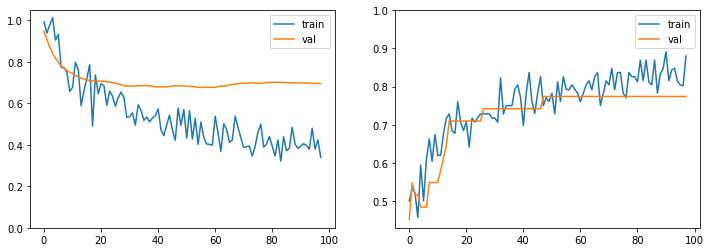

In [20]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 160, 160, 3) float32
(97,) int32
(25, 160, 160, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 169ms/step - loss: 94.9528 - val_loss: 83.5069
Epoch 2/100
100/100 [==============================] - 16s 156ms/step - loss: 76.5538 - val_loss: 75.1918
Epoch 3/100
100/100 [==============================] - 16s 156ms/step - loss: 64.9112 - val_loss: 60.8463
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 54.1449 - val_loss: 40.0497
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 41.9532 - val_loss: 34.1125
Epoch 6/100
100/100 [==============================] - 16s 156ms/step - loss: 34.5916 - val_loss: 31.5902
Epoch 7/100
100/100 [==============================] - 16s 156ms/step - loss: 27.9170 - val_loss: 30.5688
Epoch 8/100
100/100 [==============================] - 16s 156ms/step - loss: 23.5994 - val_loss: 23.3445
Epoch 9/100
100/100 [==============================] - 16s 156ms/step - loss: 19.7338 - val_loss: 22.9841
Epoch 10/100
100/100 [========================

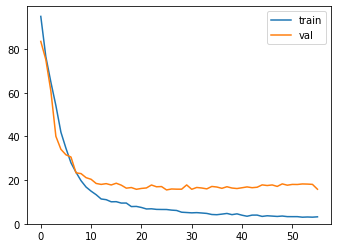

In [21]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 466ms/step - loss: 0.8363 - accuracy: 0.6250 - precision: 0.6981 - recall: 0.4014 - f1: 0.5085 - specificity: 0.8395 - negative_predictive_value: 0.5956 - matthews_correlation_coefficient: 0.2659 - equal_error_rate: 0.3646 - val_loss: 0.6348 - val_accuracy: 0.6400 - val_precision: 0.8000 - val_recall: 0.3333 - val_f1: 0.4706 - val_specificity: 0.9231 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.3203 - val_equal_error_rate: 0.0801

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32026, saving model to ../../models/siamese_networks/washed_out_2020_06_05-23_57_49.h5
Epoch 2/100
3/3 [==============================] - 0s 109ms/step - loss: 0.7319 - accuracy: 0.6915 - precision: 0.9630 - recall: 0.4014 - f1: 0.5566 - specificity: 0.9792 - negative_predictive_value: 0.6227 - matthews_correlation_coefficient: 0.4683 - equal_error_rate: 0.2757 - val_loss: 0.6204 - val_accuracy: 0

3/3 [==============================] - 0s 101ms/step - loss: 0.6911 - accuracy: 0.7128 - precision: 0.9333 - recall: 0.4653 - f1: 0.6118 - specificity: 0.9524 - negative_predictive_value: 0.6418 - matthews_correlation_coefficient: 0.4872 - equal_error_rate: 0.2563 - val_loss: 0.5109 - val_accuracy: 0.6800 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6190 - val_matthews_correlation_coefficient: 0.4543 - val_equal_error_rate: 0.0801

Epoch 00014: val_matthews_correlation_coefficient improved from 0.38435 to 0.45426, saving model to ../../models/siamese_networks/washed_out_2020_06_05-23_57_49.h5
Epoch 15/100
3/3 [==============================] - 0s 100ms/step - loss: 0.8188 - accuracy: 0.6064 - precision: 0.9167 - recall: 0.2500 - f1: 0.3921 - specificity: 0.9792 - negative_predictive_value: 0.5556 - matthews_correlation_coefficient: 0.3287 - equal_error_rate: 0.2872 - val_loss: 0.5052 - val_accuracy: 0.6800 - 

3/3 [==============================] - 0s 106ms/step - loss: 0.7440 - accuracy: 0.6277 - precision: 0.7253 - recall: 0.3958 - f1: 0.5022 - specificity: 0.8661 - negative_predictive_value: 0.5855 - matthews_correlation_coefficient: 0.2844 - equal_error_rate: 0.3095 - val_loss: 0.4566 - val_accuracy: 0.7600 - val_precision: 1.0000 - val_recall: 0.5000 - val_f1: 0.6667 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6842 - val_matthews_correlation_coefficient: 0.5849 - val_equal_error_rate: 0.0801

Epoch 00027: val_matthews_correlation_coefficient improved from 0.52042 to 0.58490, saving model to ../../models/siamese_networks/washed_out_2020_06_05-23_57_49.h5
Epoch 28/100
3/3 [==============================] - 0s 106ms/step - loss: 0.7549 - accuracy: 0.6489 - precision: 0.9167 - recall: 0.3417 - f1: 0.4891 - specificity: 0.9608 - negative_predictive_value: 0.5929 - matthews_correlation_coefficient: 0.3909 - equal_error_rate: 0.2981 - val_loss: 0.4537 - val_accuracy: 0.8000 - 

3/3 [==============================] - 0s 100ms/step - loss: 0.6566 - accuracy: 0.6596 - precision: 0.7963 - recall: 0.4250 - f1: 0.5539 - specificity: 0.8953 - negative_predictive_value: 0.6091 - matthews_correlation_coefficient: 0.3602 - equal_error_rate: 0.2980 - val_loss: 0.4357 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.5833 - val_f1: 0.7368 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.6491 - val_equal_error_rate: 0.0801

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.64907
Epoch 41/100
3/3 [==============================] - 0s 113ms/step - loss: 0.4907 - accuracy: 0.7708 - precision: 0.9259 - recall: 0.5722 - f1: 0.7073 - specificity: 0.9608 - negative_predictive_value: 0.7022 - matthews_correlation_coefficient: 0.5786 - equal_error_rate: 0.1252 - val_loss: 0.4349 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.6667 - val_f1: 0.8000 - val_specificity: 1.0000

3/3 [==============================] - 0s 101ms/step - loss: 0.5694 - accuracy: 0.7500 - precision: 1.0000 - recall: 0.4875 - f1: 0.6527 - specificity: 1.0000 - negative_predictive_value: 0.6721 - matthews_correlation_coefficient: 0.5714 - equal_error_rate: 0.2504 - val_loss: 0.4229 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.5833 - val_f1: 0.7368 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.6491 - val_equal_error_rate: 0.0801

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.71401
Epoch 54/100
3/3 [==============================] - 0s 108ms/step - loss: 0.5736 - accuracy: 0.6915 - precision: 0.9167 - recall: 0.4264 - f1: 0.5792 - specificity: 0.9596 - negative_predictive_value: 0.6250 - matthews_correlation_coefficient: 0.4569 - equal_error_rate: 0.2340 - val_loss: 0.4211 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.6667 - val_f1: 0.8000 - val_specificity: 1.0000


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.71401
Epoch 67/100
3/3 [==============================] - 0s 120ms/step - loss: 0.4631 - accuracy: 0.7872 - precision: 1.0000 - recall: 0.5833 - f1: 0.7350 - specificity: 1.0000 - negative_predictive_value: 0.6970 - matthews_correlation_coefficient: 0.6375 - equal_error_rate: 0.1592 - val_loss: 0.4004 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.6667 - val_f1: 0.8000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7647 - val_matthews_correlation_coefficient: 0.7140 - val_equal_error_rate: 0.0801

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.71401
Epoch 68/100
3/3 [==============================] - 0s 100ms/step - loss: 0.6098 - accuracy: 0.7021 - precision: 0.8547 - recall: 0.4903 - f1: 0.6184 - specificity: 0.9149 - negative_predictive_value: 0.6425 - matthews_correlation_coefficient: 0.4484 - equal_error_rate: 0.2757 - val_loss: 0.3982 - val_accuracy: 0

3/3 [==============================] - 0s 106ms/step - loss: 0.5350 - accuracy: 0.7021 - precision: 0.8667 - recall: 0.4903 - f1: 0.6214 - specificity: 0.9191 - negative_predictive_value: 0.6423 - matthews_correlation_coefficient: 0.4560 - equal_error_rate: 0.1476 - val_loss: 0.3919 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.6667 - val_f1: 0.8000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7647 - val_matthews_correlation_coefficient: 0.7140 - val_equal_error_rate: 0.0801

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.71401
Epoch 81/100
3/3 [==============================] - 0s 105ms/step - loss: 0.5646 - accuracy: 0.7500 - precision: 1.0000 - recall: 0.4889 - f1: 0.6550 - specificity: 1.0000 - negative_predictive_value: 0.6719 - matthews_correlation_coefficient: 0.5727 - equal_error_rate: 0.1878 - val_loss: 0.3913 - val_accuracy: 0.8400 - val_precision: 1.0000 - val_recall: 0.6667 - val_f1: 0.8000 - val_specificity: 1.0000

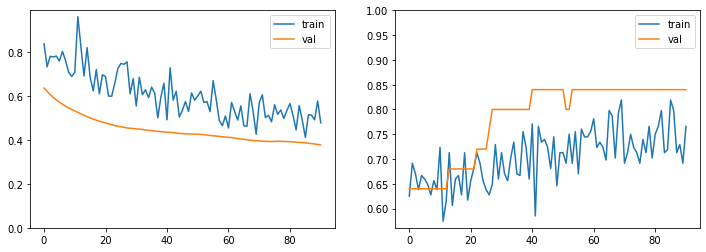

In [22]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 160, 160, 3) float32
(147,) int32
(37, 160, 160, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 19s 192ms/step - loss: 95.7146 - val_loss: 95.7675
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 88.2030 - val_loss: 91.9538
Epoch 3/100
100/100 [==============================] - 18s 181ms/step - loss: 81.6375 - val_loss: 96.5870
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 76.4874 - val_loss: 94.8596
Epoch 5/100
100/100 [==============================] - 18s 181ms/step - loss: 74.5176 - val_loss: 95.9220
Epoch 6/100
100/100 [==============================] - 18s 181ms/step - loss: 70.6746 - val_loss: 93.1161
Epoch 7/100
100/100 [==============================] - 18s 181ms/step - loss: 66.6790 - val_loss: 96.5923
Epoch 8/100
100/100 [==============================] - 18s 181ms/step - loss: 64.6879 - val_loss: 96.0249
Epoch 9/100
100/100 [==============================] - 18s 181ms/step - loss: 60.8632 - val_loss: 96.0798
Epoch 10/100
100/100 [========================

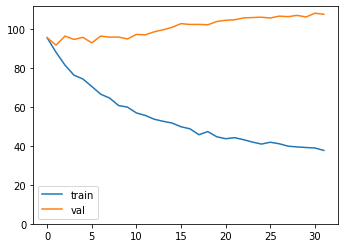

In [23]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
5/5 [==============================] - 2s 382ms/step - loss: 0.8074 - accuracy: 0.5250 - precision: 0.5147 - recall: 0.3522 - f1: 0.4158 - specificity: 0.6812 - negative_predictive_value: 0.5074 - matthews_correlation_coefficient: 0.0281 - equal_error_rate: 0.4545 - val_loss: 0.7075 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 0.5333 - val_f1: 0.5333 - val_specificity: 0.5882 - val_negative_predictive_value: 0.5882 - val_matthews_correlation_coefficient: 0.1216 - val_equal_error_rate: 0.4392

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12157, saving model to ../../models/siamese_networks/pixelation_2020_06_06-00_08_48.h5
Epoch 2/100
5/5 [==============================] - 1s 168ms/step - loss: 0.7572 - accuracy: 0.5515 - precision: 0.5389 - recall: 0.5144 - f1: 0.5077 - specificity: 0.5936 - negative_predictive_value: 0.5719 - matthews_correlation_coefficient: 0.1094 - equal_error_rate: 0.4590 - val_loss: 0.7061 - val_accuracy: 0

5/5 [==============================] - 1s 136ms/step - loss: 0.7337 - accuracy: 0.5735 - precision: 0.5950 - recall: 0.5645 - f1: 0.5593 - specificity: 0.6424 - negative_predictive_value: 0.6263 - matthews_correlation_coefficient: 0.2141 - equal_error_rate: 0.3973 - val_loss: 0.6974 - val_accuracy: 0.6562 - val_precision: 0.6111 - val_recall: 0.7333 - val_f1: 0.6667 - val_specificity: 0.5882 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.3235 - val_equal_error_rate: 0.3765

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.32348
Epoch 15/100
5/5 [==============================] - 1s 146ms/step - loss: 0.7350 - accuracy: 0.5368 - precision: 0.5998 - recall: 0.5428 - f1: 0.5562 - specificity: 0.6272 - negative_predictive_value: 0.5788 - matthews_correlation_coefficient: 0.1742 - equal_error_rate: 0.4780 - val_loss: 0.6973 - val_accuracy: 0.6562 - val_precision: 0.6111 - val_recall: 0.7333 - val_f1: 0.6667 - val_specificity: 0.5882


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.32348
Epoch 28/100
5/5 [==============================] - 1s 143ms/step - loss: 0.7163 - accuracy: 0.5735 - precision: 0.5279 - recall: 0.5250 - f1: 0.5232 - specificity: 0.6285 - negative_predictive_value: 0.6240 - matthews_correlation_coefficient: 0.1526 - equal_error_rate: 0.4163 - val_loss: 0.6938 - val_accuracy: 0.6250 - val_precision: 0.5789 - val_recall: 0.7333 - val_f1: 0.6471 - val_specificity: 0.5294 - val_negative_predictive_value: 0.6923 - val_matthews_correlation_coefficient: 0.2670 - val_equal_error_rate: 0.3765

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.32348
Epoch 29/100
5/5 [==============================] - 1s 129ms/step - loss: 0.7492 - accuracy: 0.5294 - precision: 0.5669 - recall: 0.4739 - f1: 0.5054 - specificity: 0.6602 - negative_predictive_value: 0.5694 - matthews_correlation_coefficient: 0.1352 - equal_error_rate: 0.4335 - val_loss: 0.6937 - val_accuracy: 0

5/5 [==============================] - 1s 134ms/step - loss: 0.6813 - accuracy: 0.6029 - precision: 0.6357 - recall: 0.5250 - f1: 0.5704 - specificity: 0.6840 - negative_predictive_value: 0.5942 - matthews_correlation_coefficient: 0.2191 - equal_error_rate: 0.4010 - val_loss: 0.6943 - val_accuracy: 0.5625 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5294 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.1294 - val_equal_error_rate: 0.4392

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.32348
Epoch 42/100
5/5 [==============================] - 1s 136ms/step - loss: 0.7848 - accuracy: 0.4853 - precision: 0.5359 - recall: 0.4241 - f1: 0.4700 - specificity: 0.6081 - negative_predictive_value: 0.5066 - matthews_correlation_coefficient: 0.0372 - equal_error_rate: 0.4966 - val_loss: 0.6940 - val_accuracy: 0.5625 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5294


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.32348
Epoch 55/100
5/5 [==============================] - 1s 138ms/step - loss: 0.7587 - accuracy: 0.5250 - precision: 0.5281 - recall: 0.4547 - f1: 0.4832 - specificity: 0.5910 - negative_predictive_value: 0.5249 - matthews_correlation_coefficient: 0.0494 - equal_error_rate: 0.4688 - val_loss: 0.6897 - val_accuracy: 0.5625 - val_precision: 0.5294 - val_recall: 0.6000 - val_f1: 0.5625 - val_specificity: 0.5294 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.1294 - val_equal_error_rate: 0.3765

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.32348
Epoch 56/100
5/5 [==============================] - 1s 148ms/step - loss: 0.7783 - accuracy: 0.4779 - precision: 0.4939 - recall: 0.5195 - f1: 0.4904 - specificity: 0.5291 - negative_predictive_value: 0.5604 - matthews_correlation_coefficient: 0.0515 - equal_error_rate: 0.4899 - val_loss: 0.6899 - val_accuracy: 0

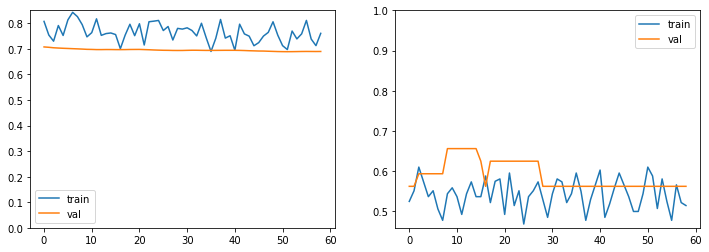

In [24]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 160, 160, 3) float32
(287,) int32
(73, 160, 160, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 25s 255ms/step - loss: 90.7594 - val_loss: 89.9406
Epoch 2/100
100/100 [==============================] - 24s 239ms/step - loss: 80.2031 - val_loss: 88.7387
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 73.6353 - val_loss: 84.6107
Epoch 4/100
100/100 [==============================] - 24s 238ms/step - loss: 71.3253 - val_loss: 85.3915
Epoch 5/100
100/100 [==============================] - 24s 238ms/step - loss: 67.6392 - val_loss: 83.5605
Epoch 6/100
100/100 [==============================] - 24s 238ms/step - loss: 65.4030 - val_loss: 84.8517
Epoch 7/100
100/100 [==============================] - 24s 238ms/step - loss: 61.4599 - val_loss: 85.5969
Epoch 8/100
100/100 [==============================] - 24s 238ms/step - loss: 60.9708 - val_loss: 85.0485
Epoch 9/100
100/100 [==============================] - 24s 238ms/step - loss: 56.0272 - val_loss: 84.2464
Epoch 10/100
100/100 [========================

100/100 [==============================] - 24s 238ms/step - loss: 19.4836 - val_loss: 72.5111
Epoch 78/100
100/100 [==============================] - 24s 238ms/step - loss: 18.5916 - val_loss: 71.2244
Epoch 79/100
100/100 [==============================] - 24s 238ms/step - loss: 18.8747 - val_loss: 71.6982
Epoch 80/100
100/100 [==============================] - 24s 238ms/step - loss: 18.9744 - val_loss: 72.6731
Epoch 81/100
100/100 [==============================] - 24s 238ms/step - loss: 18.3750 - val_loss: 71.3036
Epoch 82/100
100/100 [==============================] - 24s 238ms/step - loss: 19.6399 - val_loss: 70.4643
Epoch 83/100
100/100 [==============================] - 24s 238ms/step - loss: 18.5193 - val_loss: 72.6921
Epoch 84/100
100/100 [==============================] - 24s 238ms/step - loss: 17.6401 - val_loss: 72.9366
Epoch 85/100
100/100 [==============================] - 24s 238ms/step - loss: 19.1727 - val_loss: 70.9645
Epoch 86/100
100/100 [============================

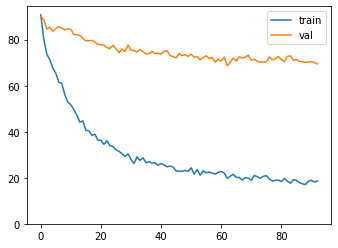

In [25]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
9/9 [==============================] - 2s 263ms/step - loss: 0.9966 - accuracy: 0.5278 - precision: 0.5467 - recall: 0.3247 - f1: 0.4034 - specificity: 0.7297 - negative_predictive_value: 0.5174 - matthews_correlation_coefficient: 0.0589 - equal_error_rate: 0.4651 - val_loss: 0.9366 - val_accuracy: 0.5469 - val_precision: 0.5722 - val_recall: 0.3438 - val_f1: 0.4292 - val_specificity: 0.7500 - val_negative_predictive_value: 0.5346 - val_matthews_correlation_coefficient: 0.1001 - val_equal_error_rate: 0.4375

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10009, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_06-00_47_34.h5
Epoch 2/100
9/9 [==============================] - 1s 119ms/step - loss: 0.9836 - accuracy: 0.5208 - precision: 0.5195 - recall: 0.3632 - f1: 0.4248 - specificity: 0.6719 - negative_predictive_value: 0.5142 - matthews_correlation_coefficient: 0.0344 - equal_error_rate: 0.4657 - val_loss: 0.8816 - val_accur


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.34911
Epoch 14/100
9/9 [==============================] - 1s 124ms/step - loss: 0.8020 - accuracy: 0.5729 - precision: 0.6012 - recall: 0.4026 - f1: 0.4757 - specificity: 0.7469 - negative_predictive_value: 0.5553 - matthews_correlation_coefficient: 0.1529 - equal_error_rate: 0.4076 - val_loss: 0.7842 - val_accuracy: 0.6094 - val_precision: 0.6857 - val_recall: 0.3750 - val_f1: 0.4816 - val_specificity: 0.8438 - val_negative_predictive_value: 0.5782 - val_matthews_correlation_coefficient: 0.2401 - val_equal_error_rate: 0.4375

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34911
Epoch 15/100
9/9 [==============================] - 1s 126ms/step - loss: 0.7776 - accuracy: 0.6076 - precision: 0.6229 - recall: 0.4441 - f1: 0.5167 - specificity: 0.7595 - negative_predictive_value: 0.5782 - matthews_correlation_coefficient: 0.2030 - equal_error_rate: 0.4152 - val_loss: 0.7793 - val_accuracy: 0

9/9 [==============================] - 1s 127ms/step - loss: 0.7128 - accuracy: 0.6250 - precision: 0.6714 - recall: 0.4908 - f1: 0.5564 - specificity: 0.7698 - negative_predictive_value: 0.6037 - matthews_correlation_coefficient: 0.2676 - equal_error_rate: 0.3724 - val_loss: 0.7739 - val_accuracy: 0.5781 - val_precision: 0.6458 - val_recall: 0.3438 - val_f1: 0.4483 - val_specificity: 0.8125 - val_negative_predictive_value: 0.5534 - val_matthews_correlation_coefficient: 0.1764 - val_equal_error_rate: 0.4062

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.34911
Epoch 28/100
9/9 [==============================] - 1s 133ms/step - loss: 0.6617 - accuracy: 0.6389 - precision: 0.6795 - recall: 0.5328 - f1: 0.5918 - specificity: 0.7240 - negative_predictive_value: 0.5986 - matthews_correlation_coefficient: 0.2670 - equal_error_rate: 0.3568 - val_loss: 0.7718 - val_accuracy: 0.5781 - val_precision: 0.6458 - val_recall: 0.3438 - val_f1: 0.4483 - val_specificity: 0.8125


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.34911
Epoch 41/100
9/9 [==============================] - 1s 128ms/step - loss: 0.7038 - accuracy: 0.6111 - precision: 0.6577 - recall: 0.4748 - f1: 0.5451 - specificity: 0.7535 - negative_predictive_value: 0.5832 - matthews_correlation_coefficient: 0.2341 - equal_error_rate: 0.4069 - val_loss: 0.7409 - val_accuracy: 0.6094 - val_precision: 0.7411 - val_recall: 0.3438 - val_f1: 0.4692 - val_specificity: 0.8750 - val_negative_predictive_value: 0.5708 - val_matthews_correlation_coefficient: 0.2612 - val_equal_error_rate: 0.4062

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.34911
Epoch 42/100
9/9 [==============================] - 1s 128ms/step - loss: 0.6554 - accuracy: 0.6354 - precision: 0.6850 - recall: 0.4779 - f1: 0.5550 - specificity: 0.7898 - negative_predictive_value: 0.6027 - matthews_correlation_coefficient: 0.2768 - equal_error_rate: 0.3520 - val_loss: 0.7410 - val_accuracy: 0

9/9 [==============================] - 1s 126ms/step - loss: 0.6679 - accuracy: 0.6146 - precision: 0.6798 - recall: 0.4721 - f1: 0.5448 - specificity: 0.7671 - negative_predictive_value: 0.5882 - matthews_correlation_coefficient: 0.2522 - equal_error_rate: 0.4056 - val_loss: 0.7199 - val_accuracy: 0.6094 - val_precision: 0.7411 - val_recall: 0.3438 - val_f1: 0.4692 - val_specificity: 0.8750 - val_negative_predictive_value: 0.5708 - val_matthews_correlation_coefficient: 0.2612 - val_equal_error_rate: 0.4062

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.34911
Epoch 55/100
9/9 [==============================] - 1s 130ms/step - loss: 0.6890 - accuracy: 0.6215 - precision: 0.6539 - recall: 0.4801 - f1: 0.5502 - specificity: 0.7370 - negative_predictive_value: 0.5870 - matthews_correlation_coefficient: 0.2283 - equal_error_rate: 0.3947 - val_loss: 0.7197 - val_accuracy: 0.5938 - val_precision: 0.6875 - val_recall: 0.3438 - val_f1: 0.4583 - val_specificity: 0.8438

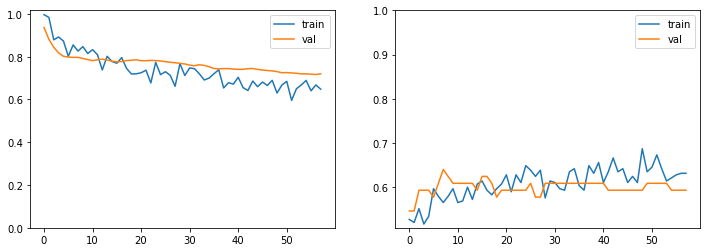

In [26]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 160, 160, 3) float32
(159,) int32
(41, 160, 160, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 196ms/step - loss: 82.6482 - val_loss: 66.7303
Epoch 2/100
100/100 [==============================] - 18s 182ms/step - loss: 65.8303 - val_loss: 64.6630
Epoch 3/100
100/100 [==============================] - 18s 182ms/step - loss: 55.5415 - val_loss: 66.7540
Epoch 4/100
100/100 [==============================] - 18s 182ms/step - loss: 44.6356 - val_loss: 66.7411
Epoch 5/100
100/100 [==============================] - 18s 183ms/step - loss: 36.6022 - val_loss: 69.1564
Epoch 6/100
100/100 [==============================] - 18s 182ms/step - loss: 30.6733 - val_loss: 71.2543
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 25.4870 - val_loss: 72.7446
Epoch 8/100
100/100 [==============================] - 18s 182ms/step - loss: 23.8694 - val_loss: 73.5480
Epoch 9/100
100/100 [==============================] - 18s 182ms/step - loss: 21.0275 - val_loss: 73.7430
Epoch 10/100
100/100 [========================

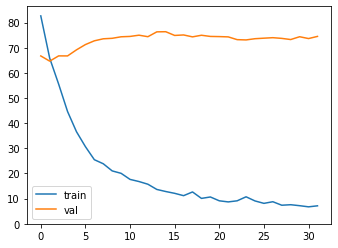

In [27]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
6/6 [==============================] - 2s 383ms/step - loss: 0.8615 - accuracy: 0.4583 - precision: 0.4520 - recall: 0.3739 - f1: 0.4061 - specificity: 0.5308 - negative_predictive_value: 0.4545 - matthews_correlation_coefficient: -0.0942 - equal_error_rate: 0.5211 - val_loss: 0.7205 - val_accuracy: 0.5938 - val_precision: 0.6250 - val_recall: 0.3333 - val_f1: 0.4348 - val_specificity: 0.8235 - val_negative_predictive_value: 0.5833 - val_matthews_correlation_coefficient: 0.1808 - val_equal_error_rate: 0.5941

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.18078, saving model to ../../models/siamese_networks/eyes_closed_2020_06_06-00_59_29.h5
Epoch 2/100
6/6 [==============================] - 1s 129ms/step - loss: 0.7930 - accuracy: 0.5427 - precision: 0.4851 - recall: 0.3912 - f1: 0.4285 - specificity: 0.5839 - negative_predictive_value: 0.5202 - matthews_correlation_coefficient: -0.0089 - equal_error_rate: 0.5295 - val_loss: 0.7178 - val_accuracy

6/6 [==============================] - 1s 134ms/step - loss: 0.6797 - accuracy: 0.5732 - precision: 0.6209 - recall: 0.5649 - f1: 0.5894 - specificity: 0.6997 - negative_predictive_value: 0.6454 - matthews_correlation_coefficient: 0.2654 - equal_error_rate: 0.4749 - val_loss: 0.6710 - val_accuracy: 0.5625 - val_precision: 0.5556 - val_recall: 0.3333 - val_f1: 0.4167 - val_specificity: 0.7647 - val_negative_predictive_value: 0.5652 - val_matthews_correlation_coefficient: 0.1088 - val_equal_error_rate: 0.4392

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.18078
Epoch 15/100
6/6 [==============================] - 1s 134ms/step - loss: 0.7564 - accuracy: 0.5573 - precision: 0.5687 - recall: 0.5020 - f1: 0.5312 - specificity: 0.6088 - negative_predictive_value: 0.5421 - matthews_correlation_coefficient: 0.1107 - equal_error_rate: 0.4585 - val_loss: 0.6694 - val_accuracy: 0.5625 - val_precision: 0.5556 - val_recall: 0.3333 - val_f1: 0.4167 - val_specificity: 0.7647


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.18078
Epoch 28/100
6/6 [==============================] - 1s 131ms/step - loss: 0.6998 - accuracy: 0.5671 - precision: 0.5558 - recall: 0.5457 - f1: 0.5217 - specificity: 0.6656 - negative_predictive_value: 0.6433 - matthews_correlation_coefficient: 0.2036 - equal_error_rate: 0.4690 - val_loss: 0.6503 - val_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.4667 - val_f1: 0.5000 - val_specificity: 0.6471 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.1156 - val_equal_error_rate: 0.3765

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.18078
Epoch 29/100
6/6 [==============================] - 1s 129ms/step - loss: 0.7202 - accuracy: 0.5938 - precision: 0.6858 - recall: 0.4283 - f1: 0.5151 - specificity: 0.7487 - negative_predictive_value: 0.5530 - matthews_correlation_coefficient: 0.2056 - equal_error_rate: 0.4536 - val_loss: 0.6483 - val_accuracy: 0

6/6 [==============================] - 1s 131ms/step - loss: 0.7256 - accuracy: 0.5915 - precision: 0.6268 - recall: 0.5421 - f1: 0.5504 - specificity: 0.7316 - negative_predictive_value: 0.6262 - matthews_correlation_coefficient: 0.2622 - equal_error_rate: 0.4443 - val_loss: 0.6249 - val_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.4667 - val_f1: 0.5000 - val_specificity: 0.6471 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.1156 - val_equal_error_rate: 0.3765

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.18146
Epoch 42/100
6/6 [==============================] - 1s 129ms/step - loss: 0.6471 - accuracy: 0.6037 - precision: 0.6535 - recall: 0.5712 - f1: 0.6076 - specificity: 0.7420 - negative_predictive_value: 0.6642 - matthews_correlation_coefficient: 0.3154 - equal_error_rate: 0.4276 - val_loss: 0.6238 - val_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.4667 - val_f1: 0.5000 - val_specificity: 0.6471


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.18146
Epoch 55/100
6/6 [==============================] - 1s 137ms/step - loss: 0.6788 - accuracy: 0.6280 - precision: 0.7100 - recall: 0.6408 - f1: 0.6713 - specificity: 0.7248 - negative_predictive_value: 0.6534 - matthews_correlation_coefficient: 0.3644 - equal_error_rate: 0.4168 - val_loss: 0.6124 - val_accuracy: 0.5938 - val_precision: 0.5714 - val_recall: 0.5333 - val_f1: 0.5517 - val_specificity: 0.6471 - val_negative_predictive_value: 0.6111 - val_matthews_correlation_coefficient: 0.1815 - val_equal_error_rate: 0.3765

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.18146
Epoch 56/100
6/6 [==============================] - 1s 129ms/step - loss: 0.6746 - accuracy: 0.6463 - precision: 0.5389 - recall: 0.4525 - f1: 0.4903 - specificity: 0.7307 - negative_predictive_value: 0.6503 - matthews_correlation_coefficient: 0.1862 - equal_error_rate: 0.4523 - val_loss: 0.6144 - val_accuracy: 0

6/6 [==============================] - 1s 132ms/step - loss: 0.6538 - accuracy: 0.6220 - precision: 0.5395 - recall: 0.4480 - f1: 0.4833 - specificity: 0.7101 - negative_predictive_value: 0.6224 - matthews_correlation_coefficient: 0.1599 - equal_error_rate: 0.4085 - val_loss: 0.6023 - val_accuracy: 0.5938 - val_precision: 0.5714 - val_recall: 0.5333 - val_f1: 0.5517 - val_specificity: 0.6471 - val_negative_predictive_value: 0.6111 - val_matthews_correlation_coefficient: 0.1815 - val_equal_error_rate: 0.3765

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.18146
Epoch 69/100
6/6 [==============================] - 1s 129ms/step - loss: 0.6588 - accuracy: 0.6341 - precision: 0.6989 - recall: 0.5795 - f1: 0.5977 - specificity: 0.7722 - negative_predictive_value: 0.6526 - matthews_correlation_coefficient: 0.3500 - equal_error_rate: 0.4100 - val_loss: 0.6037 - val_accuracy: 0.5938 - val_precision: 0.5714 - val_recall: 0.5333 - val_f1: 0.5517 - val_specificity: 0.6471

6/6 [==============================] - 1s 126ms/step - loss: 0.7231 - accuracy: 0.6280 - precision: 0.5726 - recall: 0.3984 - f1: 0.4695 - specificity: 0.7606 - negative_predictive_value: 0.6026 - matthews_correlation_coefficient: 0.1668 - equal_error_rate: 0.4548 - val_loss: 0.5963 - val_accuracy: 0.5938 - val_precision: 0.5714 - val_recall: 0.5333 - val_f1: 0.5517 - val_specificity: 0.6471 - val_negative_predictive_value: 0.6111 - val_matthews_correlation_coefficient: 0.1815 - val_equal_error_rate: 0.3765

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.30721
Epoch 82/100
6/6 [==============================] - 1s 139ms/step - loss: 0.6462 - accuracy: 0.6159 - precision: 0.6087 - recall: 0.5661 - f1: 0.5614 - specificity: 0.7205 - negative_predictive_value: 0.6627 - matthews_correlation_coefficient: 0.2777 - equal_error_rate: 0.4010 - val_loss: 0.5988 - val_accuracy: 0.5938 - val_precision: 0.5714 - val_recall: 0.5333 - val_f1: 0.5517 - val_specificity: 0.6471


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.30721
Epoch 95/100
6/6 [==============================] - 1s 135ms/step - loss: 0.6239 - accuracy: 0.6707 - precision: 0.6908 - recall: 0.6256 - f1: 0.6310 - specificity: 0.7716 - negative_predictive_value: 0.6913 - matthews_correlation_coefficient: 0.3884 - equal_error_rate: 0.3645 - val_loss: 0.6024 - val_accuracy: 0.6250 - val_precision: 0.6000 - val_recall: 0.6000 - val_f1: 0.6000 - val_specificity: 0.6471 - val_negative_predictive_value: 0.6471 - val_matthews_correlation_coefficient: 0.2471 - val_equal_error_rate: 0.3765

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.30721
Epoch 96/100
6/6 [==============================] - 1s 129ms/step - loss: 0.6698 - accuracy: 0.6463 - precision: 0.7362 - recall: 0.5994 - f1: 0.6543 - specificity: 0.7992 - negative_predictive_value: 0.6770 - matthews_correlation_coefficient: 0.4057 - equal_error_rate: 0.4064 - val_loss: 0.6013 - val_accuracy: 0

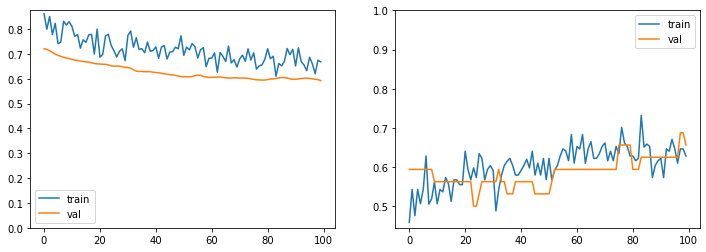

In [28]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 160, 160, 3) float32
(224,) int32
(56, 160, 160, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 24s 242ms/step - loss: 81.4410 - val_loss: 58.5370
Epoch 2/100
100/100 [==============================] - 22s 223ms/step - loss: 60.7536 - val_loss: 56.1523
Epoch 3/100
100/100 [==============================] - 22s 222ms/step - loss: 50.1139 - val_loss: 55.2229
Epoch 4/100
100/100 [==============================] - 22s 221ms/step - loss: 38.6053 - val_loss: 55.9859
Epoch 5/100
100/100 [==============================] - 22s 221ms/step - loss: 31.1646 - val_loss: 54.7559
Epoch 6/100
100/100 [==============================] - 22s 222ms/step - loss: 25.0796 - val_loss: 53.6198
Epoch 7/100
100/100 [==============================] - 22s 221ms/step - loss: 21.3132 - val_loss: 51.6805
Epoch 8/100
100/100 [==============================] - 22s 222ms/step - loss: 18.9043 - val_loss: 50.7421
Epoch 9/100
100/100 [==============================] - 22s 222ms/step - loss: 16.9401 - val_loss: 49.8693
Epoch 10/100
100/100 [========================

100/100 [==============================] - 22s 222ms/step - loss: 2.6745 - val_loss: 41.8129
Epoch 79/100
100/100 [==============================] - 22s 221ms/step - loss: 2.0580 - val_loss: 41.3550
Epoch 80/100
100/100 [==============================] - 22s 222ms/step - loss: 2.9404 - val_loss: 40.2414
Epoch 81/100
100/100 [==============================] - 22s 222ms/step - loss: 2.6725 - val_loss: 43.8045
Epoch 82/100
100/100 [==============================] - 22s 222ms/step - loss: 2.6904 - val_loss: 42.0356
Epoch 83/100
100/100 [==============================] - 22s 222ms/step - loss: 2.6079 - val_loss: 43.1629
Epoch 84/100
100/100 [==============================] - 22s 222ms/step - loss: 2.8145 - val_loss: 43.8852
Epoch 85/100
100/100 [==============================] - 22s 222ms/step - loss: 2.8050 - val_loss: 41.4879
Epoch 86/100
100/100 [==============================] - 22s 222ms/step - loss: 2.0780 - val_loss: 41.6402
Epoch 87/100
100/100 [==============================] - 22s

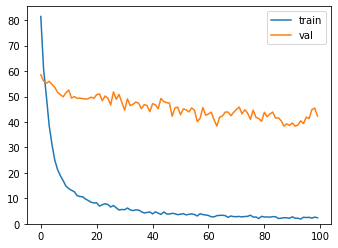

In [29]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 412ms/step - loss: 1.3131 - accuracy: 0.3661 - precision: 0.4012 - recall: 0.5638 - f1: 0.4657 - specificity: 0.1769 - negative_predictive_value: 0.2927 - matthews_correlation_coefficient: -0.2814 - equal_error_rate: 0.5935 - val_loss: 0.9463 - val_accuracy: 0.5000 - val_precision: 0.5517 - val_recall: 0.8421 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2660 - val_equal_error_rate: 0.6235

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.26605, saving model to ../../models/siamese_networks/varied_background_2020_06_06-01_39_05.h5
Epoch 2/100
7/7 [==============================] - 1s 169ms/step - loss: 1.2229 - accuracy: 0.4087 - precision: 0.4164 - recall: 0.5396 - f1: 0.4679 - specificity: 0.2617 - negative_predictive_value: 0.3796 - matthews_correlation_coefficient: -0.2014 - equal_error_rate: 0.6113 - val_loss: 0.873


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.42040
Epoch 14/100
7/7 [==============================] - 1s 112ms/step - loss: 0.7447 - accuracy: 0.6058 - precision: 0.6626 - recall: 0.4063 - f1: 0.4937 - specificity: 0.8128 - negative_predictive_value: 0.5806 - matthews_correlation_coefficient: 0.2305 - equal_error_rate: 0.3932 - val_loss: 0.7292 - val_accuracy: 0.6562 - val_precision: 0.9000 - val_recall: 0.4737 - val_f1: 0.6207 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.4204 - val_equal_error_rate: 0.4676

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.42040
Epoch 15/100
7/7 [==============================] - ETA: 0s - loss: 0.7847 - accuracy: 0.6136 - precision: 0.6146 - recall: 0.4428 - f1: 0.5059 - specificity: 0.7532 - negative_predictive_value: 0.5838 - matthews_correlation_coefficient: 0.1979 - equal_error_rate: 0.39 - 1s 107ms/step - loss: 0.7811 - accuracy: 0

7/7 [==============================] - 1s 107ms/step - loss: 0.7298 - accuracy: 0.6490 - precision: 0.7508 - recall: 0.4682 - f1: 0.5728 - specificity: 0.8339 - negative_predictive_value: 0.5960 - matthews_correlation_coefficient: 0.3231 - equal_error_rate: 0.3429 - val_loss: 0.6983 - val_accuracy: 0.6875 - val_precision: 0.9091 - val_recall: 0.5263 - val_f1: 0.6667 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4647 - val_equal_error_rate: 0.3381

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.46470
Epoch 28/100
7/7 [==============================] - 1s 112ms/step - loss: 0.6870 - accuracy: 0.7115 - precision: 0.8316 - recall: 0.5279 - f1: 0.6311 - specificity: 0.8854 - negative_predictive_value: 0.6446 - matthews_correlation_coefficient: 0.4424 - equal_error_rate: 0.2813 - val_loss: 0.6957 - val_accuracy: 0.6875 - val_precision: 0.9091 - val_recall: 0.5263 - val_f1: 0.6667 - val_specificity: 0.9231

7/7 [==============================] - 1s 114ms/step - loss: 0.6332 - accuracy: 0.7115 - precision: 0.8108 - recall: 0.5440 - f1: 0.6435 - specificity: 0.8646 - negative_predictive_value: 0.6529 - matthews_correlation_coefficient: 0.4341 - equal_error_rate: 0.3081 - val_loss: 0.6985 - val_accuracy: 0.6875 - val_precision: 0.9091 - val_recall: 0.5263 - val_f1: 0.6667 - val_specificity: 0.9231 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4647 - val_equal_error_rate: 0.3381

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.55466
Epoch 41/100
7/7 [==============================] - 1s 117ms/step - loss: 0.5910 - accuracy: 0.7366 - precision: 0.8302 - recall: 0.5806 - f1: 0.6797 - specificity: 0.8839 - negative_predictive_value: 0.6857 - matthews_correlation_coefficient: 0.4889 - equal_error_rate: 0.2186 - val_loss: 0.6955 - val_accuracy: 0.6562 - val_precision: 0.9000 - val_recall: 0.4737 - val_f1: 0.6207 - val_specificity: 0.9231


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.55466
Epoch 54/100
7/7 [==============================] - 1s 114ms/step - loss: 0.6313 - accuracy: 0.7308 - precision: 0.8243 - recall: 0.5831 - f1: 0.6766 - specificity: 0.8737 - negative_predictive_value: 0.6723 - matthews_correlation_coefficient: 0.4760 - equal_error_rate: 0.2674 - val_loss: 0.7004 - val_accuracy: 0.6875 - val_precision: 0.8462 - val_recall: 0.5789 - val_f1: 0.6875 - val_specificity: 0.8462 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.4251 - val_equal_error_rate: 0.3381

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.55466
Epoch 55/100
7/7 [==============================] - 1s 115ms/step - loss: 0.5984 - accuracy: 0.7500 - precision: 0.8414 - recall: 0.6190 - f1: 0.7052 - specificity: 0.8780 - negative_predictive_value: 0.6997 - matthews_correlation_coefficient: 0.5181 - equal_error_rate: 0.2594 - val_loss: 0.7036 - val_accuracy: 0

7/7 [==============================] - 1s 110ms/step - loss: 0.5430 - accuracy: 0.7548 - precision: 0.8715 - recall: 0.6004 - f1: 0.6990 - specificity: 0.9125 - negative_predictive_value: 0.6917 - matthews_correlation_coefficient: 0.5362 - equal_error_rate: 0.2179 - val_loss: 0.7110 - val_accuracy: 0.6875 - val_precision: 0.8462 - val_recall: 0.5789 - val_f1: 0.6875 - val_specificity: 0.8462 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.4251 - val_equal_error_rate: 0.3381

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.55466
Epoch 68/100
7/7 [==============================] - 1s 114ms/step - loss: 0.4923 - accuracy: 0.8125 - precision: 0.9066 - recall: 0.6854 - f1: 0.7766 - specificity: 0.9291 - negative_predictive_value: 0.7405 - matthews_correlation_coefficient: 0.6302 - equal_error_rate: 0.2319 - val_loss: 0.7080 - val_accuracy: 0.6875 - val_precision: 0.8462 - val_recall: 0.5789 - val_f1: 0.6875 - val_specificity: 0.8462


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.55466
Epoch 81/100
7/7 [==============================] - 1s 113ms/step - loss: 0.5370 - accuracy: 0.7946 - precision: 0.8994 - recall: 0.6627 - f1: 0.7583 - specificity: 0.9305 - negative_predictive_value: 0.7375 - matthews_correlation_coefficient: 0.6144 - equal_error_rate: 0.1747 - val_loss: 0.7153 - val_accuracy: 0.6875 - val_precision: 0.8462 - val_recall: 0.5789 - val_f1: 0.6875 - val_specificity: 0.8462 - val_negative_predictive_value: 0.5789 - val_matthews_correlation_coefficient: 0.4251 - val_equal_error_rate: 0.3117

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.55466
Epoch 82/100
7/7 [==============================] - 1s 110ms/step - loss: 0.4789 - accuracy: 0.7981 - precision: 0.9425 - recall: 0.6200 - f1: 0.7363 - specificity: 0.9541 - negative_predictive_value: 0.7241 - matthews_correlation_coefficient: 0.6165 - equal_error_rate: 0.1828 - val_loss: 0.7114 - val_accuracy: 0

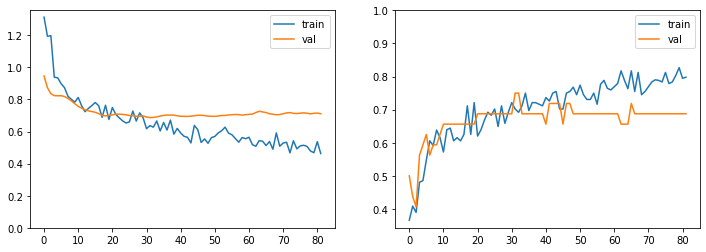

In [30]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 160, 160, 3) float32
(232,) int32
(59, 160, 160, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 26s 256ms/step - loss: 95.6594 - val_loss: 101.3409
Epoch 2/100
100/100 [==============================] - 23s 232ms/step - loss: 90.0335 - val_loss: 98.8495
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 84.4379 - val_loss: 91.5288
Epoch 4/100
100/100 [==============================] - 23s 232ms/step - loss: 82.6591 - val_loss: 88.4319
Epoch 5/100
100/100 [==============================] - 23s 232ms/step - loss: 76.6113 - val_loss: 88.6661
Epoch 6/100
100/100 [==============================] - 23s 233ms/step - loss: 75.7897 - val_loss: 89.0838
Epoch 7/100
100/100 [==============================] - 23s 232ms/step - loss: 72.7892 - val_loss: 86.1058
Epoch 8/100
100/100 [==============================] - 23s 232ms/step - loss: 70.5689 - val_loss: 84.0237
Epoch 9/100
100/100 [==============================] - 23s 232ms/step - loss: 67.6665 - val_loss: 84.9945
Epoch 10/100
100/100 [=======================

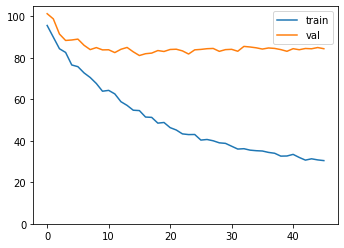

In [31]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 375ms/step - loss: 1.0049 - accuracy: 0.4732 - precision: 0.4751 - recall: 0.3525 - f1: 0.3982 - specificity: 0.6011 - negative_predictive_value: 0.4818 - matthews_correlation_coefficient: -0.0448 - equal_error_rate: 0.5757 - val_loss: 0.8629 - val_accuracy: 0.4062 - val_precision: 0.2222 - val_recall: 0.1429 - val_f1: 0.1739 - val_specificity: 0.6111 - val_negative_predictive_value: 0.4783 - val_matthews_correlation_coefficient: -0.2715 - val_equal_error_rate: 0.5635

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.27146, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_06-01_59_37.h5
Epoch 2/100
7/7 [==============================] - 1s 123ms/step - loss: 0.9629 - accuracy: 0.4952 - precision: 0.5136 - recall: 0.4056 - f1: 0.4475 - specificity: 0.5751 - negative_predictive_value: 0.4733 - matthews_correlation_coefficient: -0.0163 - equal_error_rate: 0.5210 - val_loss: 0.8504 - val_acc

7/7 [==============================] - 1s 127ms/step - loss: 0.8048 - accuracy: 0.5625 - precision: 0.5990 - recall: 0.4912 - f1: 0.5301 - specificity: 0.6468 - negative_predictive_value: 0.5499 - matthews_correlation_coefficient: 0.1433 - equal_error_rate: 0.4375 - val_loss: 0.7782 - val_accuracy: 0.4688 - val_precision: 0.2857 - val_recall: 0.1429 - val_f1: 0.1905 - val_specificity: 0.7222 - val_negative_predictive_value: 0.5200 - val_matthews_correlation_coefficient: -0.1619 - val_equal_error_rate: 0.5635

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.16190
Epoch 15/100
7/7 [==============================] - 1s 115ms/step - loss: 0.8284 - accuracy: 0.5385 - precision: 0.5854 - recall: 0.3644 - f1: 0.4417 - specificity: 0.7247 - negative_predictive_value: 0.5167 - matthews_correlation_coefficient: 0.0951 - equal_error_rate: 0.4549 - val_loss: 0.7756 - val_accuracy: 0.5000 - val_precision: 0.3333 - val_recall: 0.1429 - val_f1: 0.2000 - val_specificity: 0.77

7/7 [==============================] - 1s 128ms/step - loss: 0.7982 - accuracy: 0.5048 - precision: 0.5194 - recall: 0.4097 - f1: 0.4545 - specificity: 0.6066 - negative_predictive_value: 0.4973 - matthews_correlation_coefficient: 0.0165 - equal_error_rate: 0.4459 - val_loss: 0.7545 - val_accuracy: 0.4688 - val_precision: 0.2857 - val_recall: 0.1429 - val_f1: 0.1905 - val_specificity: 0.7222 - val_negative_predictive_value: 0.5200 - val_matthews_correlation_coefficient: -0.1619 - val_equal_error_rate: 0.5635

Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.00952
Epoch 28/100
7/7 [==============================] - 1s 134ms/step - loss: 0.7164 - accuracy: 0.5865 - precision: 0.6148 - recall: 0.4492 - f1: 0.5163 - specificity: 0.7125 - negative_predictive_value: 0.5587 - matthews_correlation_coefficient: 0.1675 - equal_error_rate: 0.4276 - val_loss: 0.7523 - val_accuracy: 0.4688 - val_precision: 0.2857 - val_recall: 0.1429 - val_f1: 0.1905 - val_specificity: 0.72

7/7 [==============================] - 1s 126ms/step - loss: 0.7283 - accuracy: 0.5577 - precision: 0.5643 - recall: 0.4246 - f1: 0.4779 - specificity: 0.6815 - negative_predictive_value: 0.5497 - matthews_correlation_coefficient: 0.1101 - equal_error_rate: 0.4333 - val_loss: 0.7358 - val_accuracy: 0.5312 - val_precision: 0.4000 - val_recall: 0.1429 - val_f1: 0.2105 - val_specificity: 0.8333 - val_negative_predictive_value: 0.5556 - val_matthews_correlation_coefficient: -0.0325 - val_equal_error_rate: 0.5437

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.04762
Epoch 41/100
7/7 [==============================] - 1s 122ms/step - loss: 0.7530 - accuracy: 0.5580 - precision: 0.6012 - recall: 0.3700 - f1: 0.4512 - specificity: 0.7480 - negative_predictive_value: 0.5450 - matthews_correlation_coefficient: 0.1312 - equal_error_rate: 0.4158 - val_loss: 0.7338 - val_accuracy: 0.5312 - val_precision: 0.4000 - val_recall: 0.1429 - val_f1: 0.2105 - val_specificity: 0.833

7/7 [==============================] - 1s 116ms/step - loss: 0.7268 - accuracy: 0.6106 - precision: 0.6435 - recall: 0.4428 - f1: 0.5214 - specificity: 0.7564 - negative_predictive_value: 0.5724 - matthews_correlation_coefficient: 0.2073 - equal_error_rate: 0.4066 - val_loss: 0.7152 - val_accuracy: 0.5625 - val_precision: 0.5000 - val_recall: 0.2143 - val_f1: 0.3000 - val_specificity: 0.8333 - val_negative_predictive_value: 0.5769 - val_matthews_correlation_coefficient: 0.0605 - val_equal_error_rate: 0.5357

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.06052
Epoch 54/100
7/7 [==============================] - 1s 124ms/step - loss: 0.6699 - accuracy: 0.5817 - precision: 0.6158 - recall: 0.4496 - f1: 0.5168 - specificity: 0.7246 - negative_predictive_value: 0.5715 - matthews_correlation_coefficient: 0.1805 - equal_error_rate: 0.3884 - val_loss: 0.7140 - val_accuracy: 0.5625 - val_precision: 0.5000 - val_recall: 0.1429 - val_f1: 0.2222 - val_specificity: 0.8889

7/7 [==============================] - 1s 122ms/step - loss: 0.6744 - accuracy: 0.6154 - precision: 0.7104 - recall: 0.4468 - f1: 0.5399 - specificity: 0.7902 - negative_predictive_value: 0.5770 - matthews_correlation_coefficient: 0.2601 - equal_error_rate: 0.3607 - val_loss: 0.6960 - val_accuracy: 0.5938 - val_precision: 0.6000 - val_recall: 0.2143 - val_f1: 0.3158 - val_specificity: 0.8889 - val_negative_predictive_value: 0.5926 - val_matthews_correlation_coefficient: 0.1410 - val_equal_error_rate: 0.5357

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.23810
Epoch 67/100
7/7 [==============================] - 1s 122ms/step - loss: 0.6296 - accuracy: 0.6394 - precision: 0.7362 - recall: 0.5151 - f1: 0.5928 - specificity: 0.8076 - negative_predictive_value: 0.6220 - matthews_correlation_coefficient: 0.3384 - equal_error_rate: 0.3073 - val_loss: 0.6944 - val_accuracy: 0.6250 - val_precision: 0.6667 - val_recall: 0.2857 - val_f1: 0.4000 - val_specificity: 0.8889

7/7 [==============================] - 1s 128ms/step - loss: 0.7320 - accuracy: 0.5577 - precision: 0.5955 - recall: 0.4318 - f1: 0.4988 - specificity: 0.6707 - negative_predictive_value: 0.5193 - matthews_correlation_coefficient: 0.1085 - equal_error_rate: 0.4274 - val_loss: 0.6866 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.3571 - val_f1: 0.4545 - val_specificity: 0.8333 - val_negative_predictive_value: 0.6250 - val_matthews_correlation_coefficient: 0.2182 - val_equal_error_rate: 0.5635

Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.31446
Epoch 80/100
7/7 [==============================] - 1s 128ms/step - loss: 0.6226 - accuracy: 0.6394 - precision: 0.6816 - recall: 0.5608 - f1: 0.6070 - specificity: 0.7136 - negative_predictive_value: 0.6233 - matthews_correlation_coefficient: 0.2886 - equal_error_rate: 0.3580 - val_loss: 0.6853 - val_accuracy: 0.5938 - val_precision: 0.5714 - val_recall: 0.2857 - val_f1: 0.3810 - val_specificity: 0.8333


Epoch 00092: val_matthews_correlation_coefficient did not improve from 0.31446
Epoch 93/100
7/7 [==============================] - 1s 131ms/step - loss: 0.6404 - accuracy: 0.6250 - precision: 0.6873 - recall: 0.5069 - f1: 0.5788 - specificity: 0.7648 - negative_predictive_value: 0.6037 - matthews_correlation_coefficient: 0.2811 - equal_error_rate: 0.3711 - val_loss: 0.6737 - val_accuracy: 0.6562 - val_precision: 0.7143 - val_recall: 0.3571 - val_f1: 0.4762 - val_specificity: 0.8889 - val_negative_predictive_value: 0.6400 - val_matthews_correlation_coefficient: 0.2952 - val_equal_error_rate: 0.4722

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.31446
Epoch 94/100
7/7 [==============================] - 1s 129ms/step - loss: 0.6179 - accuracy: 0.6683 - precision: 0.7401 - recall: 0.5541 - f1: 0.6254 - specificity: 0.8048 - negative_predictive_value: 0.6436 - matthews_correlation_coefficient: 0.3709 - equal_error_rate: 0.3572 - val_loss: 0.6720 - val_accuracy: 0

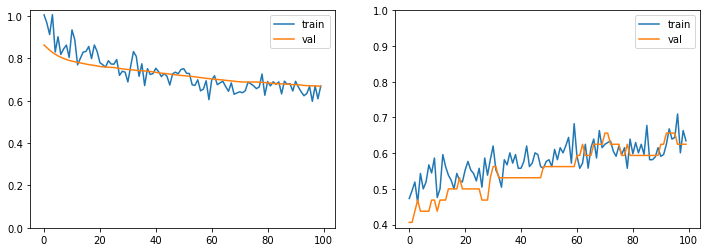

In [32]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 160, 160, 3) float32
(123,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 20s 204ms/step - loss: 84.4812 - val_loss: 71.6969
Epoch 2/100
100/100 [==============================] - 18s 180ms/step - loss: 63.5996 - val_loss: 73.0327
Epoch 3/100
100/100 [==============================] - 18s 180ms/step - loss: 49.5431 - val_loss: 75.7565
Epoch 4/100
100/100 [==============================] - 18s 180ms/step - loss: 39.6806 - val_loss: 77.7306
Epoch 5/100
100/100 [==============================] - 18s 180ms/step - loss: 33.5580 - val_loss: 81.1063
Epoch 6/100
100/100 [==============================] - 18s 180ms/step - loss: 28.6603 - val_loss: 80.5283
Epoch 7/100
100/100 [==============================] - 18s 180ms/step - loss: 26.9694 - val_loss: 77.2641
Epoch 8/100
100/100 [==============================] - 18s 179ms/step - loss: 20.6991 - val_loss: 79.5178
Epoch 9/100
100/100 [==============================] - 18s 180ms/step - loss: 19.3652 - val_loss: 81.9054
Epoch 10/100
100/100 [========================

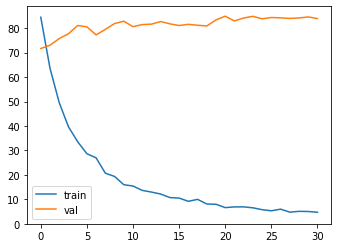

In [33]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 658ms/step - loss: 0.8004 - accuracy: 0.5625 - precision: 0.5647 - recall: 0.5670 - f1: 0.5623 - specificity: 0.5646 - negative_predictive_value: 0.5670 - matthews_correlation_coefficient: 0.1316 - equal_error_rate: 0.4067 - val_loss: 0.6965 - val_accuracy: 0.5161 - val_precision: 0.5000 - val_recall: 0.6667 - val_f1: 0.5714 - val_specificity: 0.3750 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.0435 - val_equal_error_rate: 0.4208

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04352, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_06-02_11_54.h5
Epoch 2/100
4/4 [==============================] - 1s 201ms/step - loss: 0.7838 - accuracy: 0.4412 - precision: 0.3845 - recall: 0.3528 - f1: 0.3641 - specificity: 0.4083 - negative_predictive_value: 0.3522 - matthews_correlation_coefficient: -0.2508 - equal_error_rate: 0.5473 - val_loss: 0.6950 - 

4/4 [==============================] - 1s 160ms/step - loss: 0.6825 - accuracy: 0.5294 - precision: 0.6295 - recall: 0.6397 - f1: 0.6299 - specificity: 0.6167 - negative_predictive_value: 0.6267 - matthews_correlation_coefficient: 0.2563 - equal_error_rate: 0.4170 - val_loss: 0.6798 - val_accuracy: 0.5806 - val_precision: 0.5500 - val_recall: 0.7333 - val_f1: 0.6286 - val_specificity: 0.4375 - val_negative_predictive_value: 0.6364 - val_matthews_correlation_coefficient: 0.1784 - val_equal_error_rate: 0.3229

Epoch 00014: val_matthews_correlation_coefficient improved from 0.04352 to 0.17843, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_06-02_11_54.h5
Epoch 15/100
4/4 [==============================] - 1s 154ms/step - loss: 0.7081 - accuracy: 0.5000 - precision: 0.5956 - recall: 0.4830 - f1: 0.4930 - specificity: 0.5816 - negative_predictive_value: 0.5338 - matthews_correlation_coefficient: 0.0921 - equal_error_rate: 0.4324 - val_loss: 0.6782 - val_accur


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 27/100
4/4 [==============================] - 1s 164ms/step - loss: 0.6179 - accuracy: 0.5882 - precision: 0.6000 - recall: 0.7738 - f1: 0.6749 - specificity: 0.5017 - negative_predictive_value: 0.7034 - matthews_correlation_coefficient: 0.2890 - equal_error_rate: 0.3001 - val_loss: 0.6665 - val_accuracy: 0.7097 - val_precision: 0.6250 - val_recall: 1.0000 - val_f1: 0.7692 - val_specificity: 0.4375 - val_negative_predictive_value: 1.0000 - val_matthews_correlation_coefficient: 0.5229 - val_equal_error_rate: 0.3229

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 28/100
4/4 [==============================] - 1s 156ms/step - loss: 0.7199 - accuracy: 0.5686 - precision: 0.6045 - recall: 0.6032 - f1: 0.6013 - specificity: 0.5750 - negative_predictive_value: 0.5761 - matthews_correlation_coefficient: 0.1794 - equal_error_rate: 0.4765 - val_loss: 0.6675 - val_accuracy: 0

4/4 [==============================] - 1s 151ms/step - loss: 0.6649 - accuracy: 0.5588 - precision: 0.5863 - recall: 0.6815 - f1: 0.6287 - specificity: 0.5434 - negative_predictive_value: 0.6579 - matthews_correlation_coefficient: 0.2342 - equal_error_rate: 0.3855 - val_loss: 0.6738 - val_accuracy: 0.7097 - val_precision: 0.6500 - val_recall: 0.8667 - val_f1: 0.7429 - val_specificity: 0.5625 - val_negative_predictive_value: 0.8182 - val_matthews_correlation_coefficient: 0.4482 - val_equal_error_rate: 0.3875

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 41/100
4/4 [==============================] - 1s 159ms/step - loss: 0.7168 - accuracy: 0.5625 - precision: 0.5685 - recall: 0.5450 - f1: 0.5490 - specificity: 0.5813 - negative_predictive_value: 0.5645 - matthews_correlation_coefficient: 0.1295 - equal_error_rate: 0.4615 - val_loss: 0.6727 - val_accuracy: 0.6774 - val_precision: 0.6190 - val_recall: 0.8667 - val_f1: 0.7222 - val_specificity: 0.5000


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 54/100
4/4 [==============================] - 1s 156ms/step - loss: 0.6613 - accuracy: 0.6078 - precision: 0.5951 - recall: 0.6005 - f1: 0.5917 - specificity: 0.5694 - negative_predictive_value: 0.5785 - matthews_correlation_coefficient: 0.1718 - equal_error_rate: 0.3311 - val_loss: 0.6671 - val_accuracy: 0.6774 - val_precision: 0.6316 - val_recall: 0.8000 - val_f1: 0.7059 - val_specificity: 0.5625 - val_negative_predictive_value: 0.7500 - val_matthews_correlation_coefficient: 0.3719 - val_equal_error_rate: 0.3875

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 55/100
4/4 [==============================] - 1s 145ms/step - loss: 0.6497 - accuracy: 0.5980 - precision: 0.5788 - recall: 0.4992 - f1: 0.5339 - specificity: 0.6535 - negative_predictive_value: 0.5755 - matthews_correlation_coefficient: 0.1535 - equal_error_rate: 0.4302 - val_loss: 0.6677 - val_accuracy: 0

4/4 [==============================] - 1s 151ms/step - loss: 0.6629 - accuracy: 0.5686 - precision: 0.6759 - recall: 0.5142 - f1: 0.5791 - specificity: 0.7330 - negative_predictive_value: 0.6008 - matthews_correlation_coefficient: 0.2615 - equal_error_rate: 0.4014 - val_loss: 0.6739 - val_accuracy: 0.6452 - val_precision: 0.6000 - val_recall: 0.8000 - val_f1: 0.6857 - val_specificity: 0.5000 - val_negative_predictive_value: 0.7273 - val_matthews_correlation_coefficient: 0.3133 - val_equal_error_rate: 0.3875

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.52291
Epoch 68/100
4/4 [==============================] - 1s 149ms/step - loss: 0.6029 - accuracy: 0.6765 - precision: 0.7798 - recall: 0.6327 - f1: 0.6958 - specificity: 0.7865 - negative_predictive_value: 0.6622 - matthews_correlation_coefficient: 0.4302 - equal_error_rate: 0.3149 - val_loss: 0.6737 - val_accuracy: 0.6452 - val_precision: 0.6000 - val_recall: 0.8000 - val_f1: 0.6857 - val_specificity: 0.5000

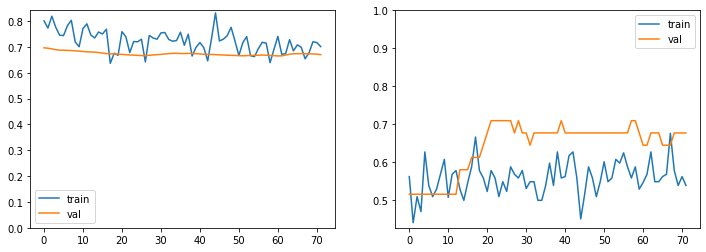

In [34]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 160, 160, 3) float32
(93,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 18s 179ms/step - loss: 90.9368 - val_loss: 80.8066
Epoch 2/100
100/100 [==============================] - 16s 160ms/step - loss: 73.8152 - val_loss: 64.7993
Epoch 3/100
100/100 [==============================] - 16s 160ms/step - loss: 58.8276 - val_loss: 50.0950
Epoch 4/100
100/100 [==============================] - 16s 160ms/step - loss: 44.3193 - val_loss: 43.3088
Epoch 5/100
100/100 [==============================] - 16s 160ms/step - loss: 34.5122 - val_loss: 37.0547
Epoch 6/100
100/100 [==============================] - 16s 160ms/step - loss: 26.6871 - val_loss: 33.8548
Epoch 7/100
100/100 [==============================] - 16s 160ms/step - loss: 20.2950 - val_loss: 29.3654
Epoch 8/100
100/100 [==============================] - 16s 160ms/step - loss: 16.8445 - val_loss: 29.1412
Epoch 9/100
100/100 [==============================] - 16s 160ms/step - loss: 12.8844 - val_loss: 28.0279
Epoch 10/100
100/100 [========================

100/100 [==============================] - 16s 160ms/step - loss: 0.5989 - val_loss: 22.1529
Epoch 79/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6255 - val_loss: 22.3771
Epoch 80/100
100/100 [==============================] - 16s 160ms/step - loss: 0.5461 - val_loss: 21.2504
Epoch 81/100
100/100 [==============================] - 16s 160ms/step - loss: 0.7062 - val_loss: 21.5388
Epoch 82/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6629 - val_loss: 22.2726
Epoch 83/100
100/100 [==============================] - 16s 160ms/step - loss: 0.7132 - val_loss: 23.0158
Epoch 84/100
100/100 [==============================] - 16s 159ms/step - loss: 0.5791 - val_loss: 23.5105
Epoch 85/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6308 - val_loss: 23.5056
Epoch 86/100
100/100 [==============================] - 16s 159ms/step - loss: 0.6219 - val_loss: 22.8882
Epoch 87/100
100/100 [==============================] - 16s

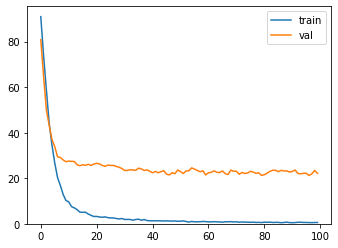

In [35]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 813ms/step - loss: 0.9387 - accuracy: 0.5938 - precision: 0.7321 - recall: 0.3273 - f1: 0.4523 - specificity: 0.8697 - negative_predictive_value: 0.5528 - matthews_correlation_coefficient: 0.2369 - equal_error_rate: 0.3948 - val_loss: 0.8961 - val_accuracy: 0.5417 - val_precision: 1.0000 - val_recall: 0.0833 - val_f1: 0.1538 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5217 - val_matthews_correlation_coefficient: 0.2085 - val_equal_error_rate: 0.2917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20851, saving model to ../../models/siamese_networks/red_eyes_2020_06_06-02_40_54.h5
Epoch 2/100
3/3 [==============================] - 0s 120ms/step - loss: 0.7364 - accuracy: 0.6848 - precision: 0.8056 - recall: 0.4552 - f1: 0.5792 - specificity: 0.8929 - negative_predictive_value: 0.6411 - matthews_correlation_coefficient: 0.3941 - equal_error_rate: 0.3566 - val_loss: 0.8752 - val_accuracy: 0.5

3/3 [==============================] - 0s 120ms/step - loss: 0.7440 - accuracy: 0.6630 - precision: 0.7424 - recall: 0.4621 - f1: 0.5616 - specificity: 0.8537 - negative_predictive_value: 0.6381 - matthews_correlation_coefficient: 0.3460 - equal_error_rate: 0.3598 - val_loss: 0.6578 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.4472 - val_equal_error_rate: 0.2917

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.44721
Epoch 15/100
3/3 [==============================] - 0s 116ms/step - loss: 0.7496 - accuracy: 0.6739 - precision: 0.9048 - recall: 0.3983 - f1: 0.5485 - specificity: 0.9582 - negative_predictive_value: 0.6150 - matthews_correlation_coefficient: 0.4301 - equal_error_rate: 0.3697 - val_loss: 0.6444 - val_accuracy: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000

3/3 [==============================] - 0s 118ms/step - loss: 0.6513 - accuracy: 0.6739 - precision: 0.8630 - recall: 0.4499 - f1: 0.5700 - specificity: 0.9137 - negative_predictive_value: 0.6269 - matthews_correlation_coefficient: 0.4195 - equal_error_rate: 0.2377 - val_loss: 0.5187 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.5833 - val_f1: 0.7368 - val_specificity: 1.0000 - val_negative_predictive_value: 0.7059 - val_matthews_correlation_coefficient: 0.6417 - val_equal_error_rate: 0.2917

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.64169
Epoch 28/100
3/3 [==============================] - 0s 126ms/step - loss: 0.6870 - accuracy: 0.6413 - precision: 0.8274 - recall: 0.3923 - f1: 0.5311 - specificity: 0.9063 - negative_predictive_value: 0.5883 - matthews_correlation_coefficient: 0.3522 - equal_error_rate: 0.3107 - val_loss: 0.5118 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.5833 - val_f1: 0.7368 - val_specificity: 1.0000

3/3 [==============================] - 0s 121ms/step - loss: 0.6543 - accuracy: 0.7391 - precision: 0.8727 - recall: 0.5873 - f1: 0.6969 - specificity: 0.9079 - negative_predictive_value: 0.6791 - matthews_correlation_coefficient: 0.5226 - equal_error_rate: 0.2479 - val_loss: 0.4480 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500 - val_f1: 0.8571 - val_specificity: 1.0000 - val_negative_predictive_value: 0.8000 - val_matthews_correlation_coefficient: 0.7746 - val_equal_error_rate: 0.2083

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.77460
Epoch 41/100
3/3 [==============================] - 0s 123ms/step - loss: 0.6017 - accuracy: 0.7708 - precision: 0.9722 - recall: 0.5824 - f1: 0.7147 - specificity: 0.9804 - negative_predictive_value: 0.6958 - matthews_correlation_coefficient: 0.6120 - equal_error_rate: 0.2392 - val_loss: 0.4434 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500 - val_f1: 0.8571 - val_specificity: 1.0000


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.77460
Epoch 54/100
3/3 [==============================] - 0s 126ms/step - loss: 0.5196 - accuracy: 0.7826 - precision: 0.9327 - recall: 0.5912 - f1: 0.7212 - specificity: 0.9569 - negative_predictive_value: 0.7198 - matthews_correlation_coefficient: 0.5976 - equal_error_rate: 0.2284 - val_loss: 0.3988 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500 - val_f1: 0.7826 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7692 - val_matthews_correlation_coefficient: 0.5854 - val_equal_error_rate: 0.2083

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.77460
Epoch 55/100
3/3 [==============================] - 0s 126ms/step - loss: 0.6340 - accuracy: 0.7174 - precision: 0.8593 - recall: 0.5239 - f1: 0.6477 - specificity: 0.9163 - negative_predictive_value: 0.6582 - matthews_correlation_coefficient: 0.4773 - equal_error_rate: 0.2728 - val_loss: 0.3968 - val_accuracy: 0

3/3 [==============================] - 0s 131ms/step - loss: 0.6553 - accuracy: 0.7174 - precision: 0.8833 - recall: 0.5205 - f1: 0.6505 - specificity: 0.9090 - negative_predictive_value: 0.6530 - matthews_correlation_coefficient: 0.4788 - equal_error_rate: 0.2377 - val_loss: 0.3880 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500 - val_f1: 0.7826 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7692 - val_matthews_correlation_coefficient: 0.5854 - val_equal_error_rate: 0.2083

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.77460
Epoch 68/100
3/3 [==============================] - 0s 131ms/step - loss: 0.6037 - accuracy: 0.7609 - precision: 0.8981 - recall: 0.5915 - f1: 0.7130 - specificity: 0.9317 - negative_predictive_value: 0.6872 - matthews_correlation_coefficient: 0.5533 - equal_error_rate: 0.2090 - val_loss: 0.3879 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500 - val_f1: 0.7826 - val_specificity: 0.8333


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.77460
Epoch 81/100
3/3 [==============================] - 0s 129ms/step - loss: 0.4668 - accuracy: 0.7292 - precision: 0.9667 - recall: 0.4986 - f1: 0.6474 - specificity: 0.9792 - negative_predictive_value: 0.6531 - matthews_correlation_coefficient: 0.5430 - equal_error_rate: 0.1770 - val_loss: 0.3663 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500 - val_f1: 0.7826 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7692 - val_matthews_correlation_coefficient: 0.5854 - val_equal_error_rate: 0.2083

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.77460
Epoch 82/100
3/3 [==============================] - 0s 134ms/step - loss: 0.4334 - accuracy: 0.8152 - precision: 0.9697 - recall: 0.6323 - f1: 0.7623 - specificity: 0.9792 - negative_predictive_value: 0.7460 - matthews_correlation_coefficient: 0.6609 - equal_error_rate: 0.1866 - val_loss: 0.3649 - val_accuracy: 0

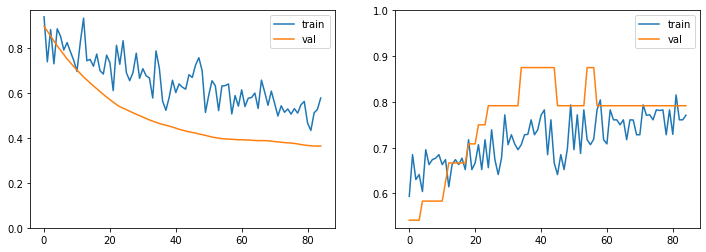

In [36]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 160, 160, 3) float32
(154,) int32
(39, 160, 160, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 23s 235ms/step - loss: 79.9208 - val_loss: 79.3335
Epoch 2/100
100/100 [==============================] - 21s 208ms/step - loss: 64.6601 - val_loss: 72.8415
Epoch 3/100
100/100 [==============================] - 21s 208ms/step - loss: 55.5489 - val_loss: 69.4496
Epoch 4/100
100/100 [==============================] - 21s 208ms/step - loss: 47.8205 - val_loss: 68.5649
Epoch 5/100
100/100 [==============================] - 21s 208ms/step - loss: 41.7436 - val_loss: 64.2949
Epoch 6/100
100/100 [==============================] - 21s 209ms/step - loss: 36.7871 - val_loss: 63.0610
Epoch 7/100
100/100 [==============================] - 21s 208ms/step - loss: 32.7043 - val_loss: 60.3345
Epoch 8/100
100/100 [==============================] - 21s 208ms/step - loss: 29.7710 - val_loss: 58.2046
Epoch 9/100
100/100 [==============================] - 21s 208ms/step - loss: 26.6246 - val_loss: 58.9425
Epoch 10/100
100/100 [========================

100/100 [==============================] - 21s 208ms/step - loss: 3.1450 - val_loss: 44.1826
Epoch 79/100
100/100 [==============================] - 21s 208ms/step - loss: 3.1595 - val_loss: 43.0275
Epoch 80/100
100/100 [==============================] - 21s 209ms/step - loss: 3.0622 - val_loss: 41.2663
Epoch 81/100
100/100 [==============================] - 21s 208ms/step - loss: 3.0533 - val_loss: 41.1253
Epoch 82/100
100/100 [==============================] - 21s 208ms/step - loss: 2.7431 - val_loss: 41.5943
Epoch 83/100
100/100 [==============================] - 21s 208ms/step - loss: 3.2001 - val_loss: 42.7336
Epoch 84/100
100/100 [==============================] - 21s 208ms/step - loss: 2.7237 - val_loss: 43.7103
Epoch 85/100
100/100 [==============================] - 21s 208ms/step - loss: 2.8474 - val_loss: 43.4220
Epoch 86/100
100/100 [==============================] - 21s 208ms/step - loss: 2.9888 - val_loss: 43.0018
Epoch 87/100
100/100 [==============================] - 21s

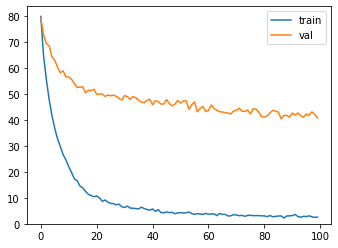

In [37]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 699ms/step - loss: 1.1139 - accuracy: 0.5469 - precision: 0.5813 - recall: 0.3974 - f1: 0.4660 - specificity: 0.6996 - negative_predictive_value: 0.5402 - matthews_correlation_coefficient: 0.1087 - equal_error_rate: 0.4292 - val_loss: 0.7309 - val_accuracy: 0.7188 - val_precision: 1.0000 - val_recall: 0.3571 - val_f1: 0.5263 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.4880 - val_equal_error_rate: 0.3452

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.48795, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_06-03_18_05.h5
Epoch 2/100
4/4 [==============================] - 1s 130ms/step - loss: 0.9645 - accuracy: 0.6111 - precision: 0.7003 - recall: 0.4461 - f1: 0.5441 - specificity: 0.7821 - negative_predictive_value: 0.5659 - matthews_correlation_coefficient: 0.2465 - equal_error_rate: 0.4262 - val_loss: 0.7206 - val_ac

4/4 [==============================] - 0s 103ms/step - loss: 0.8339 - accuracy: 0.6111 - precision: 0.6639 - recall: 0.3739 - f1: 0.4754 - specificity: 0.8349 - negative_predictive_value: 0.5885 - matthews_correlation_coefficient: 0.2294 - equal_error_rate: 0.4045 - val_loss: 0.6672 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.1429 - val_f1: 0.2500 - val_specificity: 1.0000 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.2928 - val_equal_error_rate: 0.3452

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.48795
Epoch 15/100
4/4 [==============================] - 0s 105ms/step - loss: 0.9446 - accuracy: 0.5873 - precision: 0.6973 - recall: 0.3572 - f1: 0.4706 - specificity: 0.8306 - negative_predictive_value: 0.5475 - matthews_correlation_coefficient: 0.2141 - equal_error_rate: 0.3983 - val_loss: 0.6643 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.1429 - val_f1: 0.2500 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.48795
Epoch 28/100
4/4 [==============================] - 0s 115ms/step - loss: 0.6673 - accuracy: 0.7063 - precision: 0.8649 - recall: 0.4866 - f1: 0.6162 - specificity: 0.9266 - negative_predictive_value: 0.6491 - matthews_correlation_coefficient: 0.4604 - equal_error_rate: 0.3424 - val_loss: 0.6381 - val_accuracy: 0.5938 - val_precision: 0.6667 - val_recall: 0.1429 - val_f1: 0.2353 - val_specificity: 0.9444 - val_negative_predictive_value: 0.5862 - val_matthews_correlation_coefficient: 0.1486 - val_equal_error_rate: 0.2817

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.48795
Epoch 29/100
4/4 [==============================] - 1s 132ms/step - loss: 0.7447 - accuracy: 0.6508 - precision: 0.6913 - recall: 0.5083 - f1: 0.5820 - specificity: 0.7881 - negative_predictive_value: 0.6306 - matthews_correlation_coefficient: 0.3088 - equal_error_rate: 0.3499 - val_loss: 0.6397 - val_accuracy: 0

4/4 [==============================] - 0s 115ms/step - loss: 0.6084 - accuracy: 0.7500 - precision: 0.9068 - recall: 0.5680 - f1: 0.6925 - specificity: 0.9361 - negative_predictive_value: 0.6864 - matthews_correlation_coefficient: 0.5466 - equal_error_rate: 0.2653 - val_loss: 0.6521 - val_accuracy: 0.6562 - val_precision: 0.8000 - val_recall: 0.2857 - val_f1: 0.4211 - val_specificity: 0.9444 - val_negative_predictive_value: 0.6296 - val_matthews_correlation_coefficient: 0.3145 - val_equal_error_rate: 0.2540

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.48795
Epoch 42/100
4/4 [==============================] - 0s 119ms/step - loss: 0.7017 - accuracy: 0.7143 - precision: 0.8911 - recall: 0.5325 - f1: 0.6451 - specificity: 0.9210 - negative_predictive_value: 0.6537 - matthews_correlation_coefficient: 0.4941 - equal_error_rate: 0.2690 - val_loss: 0.6502 - val_accuracy: 0.6562 - val_precision: 0.8000 - val_recall: 0.2857 - val_f1: 0.4211 - val_specificity: 0.9444

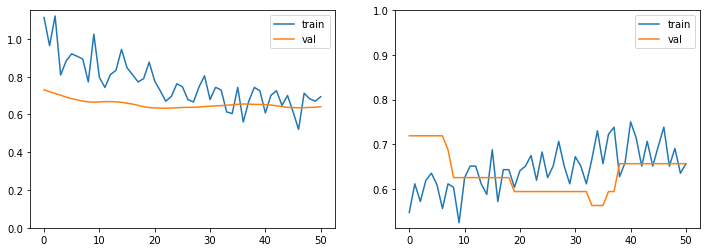

In [38]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 160, 160, 3) float32
(238,) int32
(61, 160, 160, 3) float32
(61,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 27s 274ms/step - loss: 82.3136 - val_loss: 68.9241
Epoch 2/100
100/100 [==============================] - 23s 233ms/step - loss: 64.5891 - val_loss: 61.1842
Epoch 3/100
100/100 [==============================] - 23s 235ms/step - loss: 54.9834 - val_loss: 57.5703
Epoch 4/100
100/100 [==============================] - 23s 233ms/step - loss: 46.0257 - val_loss: 54.8420
Epoch 5/100
100/100 [==============================] - 23s 233ms/step - loss: 38.1100 - val_loss: 54.5875
Epoch 6/100
100/100 [==============================] - 23s 233ms/step - loss: 34.0549 - val_loss: 53.7420
Epoch 7/100
100/100 [==============================] - 23s 233ms/step - loss: 27.6916 - val_loss: 50.7870
Epoch 8/100
100/100 [==============================] - 23s 233ms/step - loss: 24.9870 - val_loss: 50.1131
Epoch 9/100
100/100 [==============================] - 23s 234ms/step - loss: 21.1095 - val_loss: 49.1234
Epoch 10/100
100/100 [========================

100/100 [==============================] - 23s 233ms/step - loss: 4.8271 - val_loss: 39.4855
Epoch 79/100
100/100 [==============================] - 23s 234ms/step - loss: 5.3909 - val_loss: 38.5136
Epoch 80/100
100/100 [==============================] - 23s 234ms/step - loss: 4.1341 - val_loss: 38.2245
Epoch 81/100
100/100 [==============================] - 23s 233ms/step - loss: 5.9060 - val_loss: 37.5459
Epoch 82/100
100/100 [==============================] - 23s 234ms/step - loss: 4.4346 - val_loss: 38.3365
Epoch 83/100
100/100 [==============================] - 23s 233ms/step - loss: 4.3504 - val_loss: 38.0392
Epoch 84/100
100/100 [==============================] - 23s 233ms/step - loss: 4.7450 - val_loss: 37.8694
Epoch 85/100
100/100 [==============================] - 23s 233ms/step - loss: 5.2565 - val_loss: 37.0144
Epoch 86/100
100/100 [==============================] - 23s 234ms/step - loss: 4.9081 - val_loss: 38.7357
Epoch 87/100
100/100 [==============================] - 23s

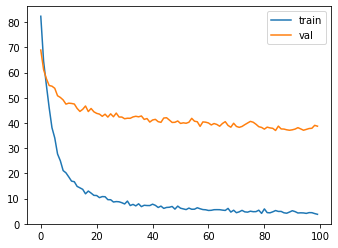

In [39]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 4s 537ms/step - loss: 1.1876 - accuracy: 0.4554 - precision: 0.4494 - recall: 0.5768 - f1: 0.4959 - specificity: 0.3420 - negative_predictive_value: 0.4724 - matthews_correlation_coefficient: -0.0798 - equal_error_rate: 0.5370 - val_loss: 1.1550 - val_accuracy: 0.3906 - val_precision: 0.3934 - val_recall: 0.4098 - val_f1: 0.4006 - val_specificity: 0.3725 - val_negative_predictive_value: 0.3896 - val_matthews_correlation_coefficient: -0.2173 - val_equal_error_rate: 0.5775

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.21734, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_06-03_59_38.h5
Epoch 2/100
7/7 [==============================] - 1s 168ms/step - loss: 1.1880 - accuracy: 0.4273 - precision: 0.4334 - recall: 0.4574 - f1: 0.4317 - specificity: 0.4111 - negative_predictive_value: 0.4365 - matthews_correlation_coefficient: -0.1308 - equal_error_rate: 0.5954 - val_loss: 1.0868 - va


Epoch 00013: val_matthews_correlation_coefficient improved from 0.27558 to 0.30810, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_06-03_59_38.h5
Epoch 14/100
7/7 [==============================] - 1s 126ms/step - loss: 0.7457 - accuracy: 0.6545 - precision: 0.6923 - recall: 0.5062 - f1: 0.5779 - specificity: 0.7933 - negative_predictive_value: 0.6345 - matthews_correlation_coefficient: 0.3126 - equal_error_rate: 0.3607 - val_loss: 0.7515 - val_accuracy: 0.6406 - val_precision: 0.7708 - val_recall: 0.4059 - val_f1: 0.5300 - val_specificity: 0.8784 - val_negative_predictive_value: 0.5960 - val_matthews_correlation_coefficient: 0.3229 - val_equal_error_rate: 0.2971

Epoch 00014: val_matthews_correlation_coefficient improved from 0.30810 to 0.32290, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_06-03_59_38.h5
Epoch 15/100
7/7 [==============================] - 1s 123ms/step - loss: 0.8535 - accuracy: 0.5773 - precision: 0.6307 - reca


Epoch 00026: val_matthews_correlation_coefficient improved from 0.54283 to 0.55412, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_06-03_59_38.h5
Epoch 27/100
7/7 [==============================] - 1s 131ms/step - loss: 0.6908 - accuracy: 0.6409 - precision: 0.6811 - recall: 0.5229 - f1: 0.5812 - specificity: 0.7586 - negative_predictive_value: 0.6055 - matthews_correlation_coefficient: 0.2836 - equal_error_rate: 0.3439 - val_loss: 0.6279 - val_accuracy: 0.7500 - val_precision: 0.9167 - val_recall: 0.5686 - val_f1: 0.6904 - val_specificity: 0.9412 - val_negative_predictive_value: 0.6875 - val_matthews_correlation_coefficient: 0.5541 - val_equal_error_rate: 0.2971

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.55412
Epoch 28/100
7/7 [==============================] - 1s 124ms/step - loss: 0.7068 - accuracy: 0.6727 - precision: 0.7773 - recall: 0.4290 - f1: 0.5521 - specificity: 0.8968 - negative_predictive_value: 0.6215 - matthews_c

7/7 [==============================] - 1s 134ms/step - loss: 0.6631 - accuracy: 0.6727 - precision: 0.7345 - recall: 0.5700 - f1: 0.6385 - specificity: 0.7849 - negative_predictive_value: 0.6225 - matthews_correlation_coefficient: 0.3558 - equal_error_rate: 0.3427 - val_loss: 0.5528 - val_accuracy: 0.7812 - val_precision: 0.9167 - val_recall: 0.6275 - val_f1: 0.7407 - val_specificity: 0.9412 - val_negative_predictive_value: 0.7159 - val_matthews_correlation_coefficient: 0.5996 - val_equal_error_rate: 0.2490

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.59961
Epoch 41/100
7/7 [==============================] - 1s 130ms/step - loss: 0.5828 - accuracy: 0.7054 - precision: 0.7642 - recall: 0.5753 - f1: 0.6540 - specificity: 0.8327 - negative_predictive_value: 0.6636 - matthews_correlation_coefficient: 0.4176 - equal_error_rate: 0.2571 - val_loss: 0.5512 - val_accuracy: 0.7812 - val_precision: 0.9167 - val_recall: 0.6275 - val_f1: 0.7407 - val_specificity: 0.9412


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.59961
Epoch 54/100
7/7 [==============================] - 1s 136ms/step - loss: 0.5139 - accuracy: 0.7318 - precision: 0.7729 - recall: 0.6079 - f1: 0.6737 - specificity: 0.8476 - negative_predictive_value: 0.7024 - matthews_correlation_coefficient: 0.4650 - equal_error_rate: 0.2399 - val_loss: 0.5050 - val_accuracy: 0.7656 - val_precision: 0.9167 - val_recall: 0.5980 - val_f1: 0.7165 - val_specificity: 0.9412 - val_negative_predictive_value: 0.7011 - val_matthews_correlation_coefficient: 0.5768 - val_equal_error_rate: 0.2343

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.59961
Epoch 55/100
7/7 [==============================] - 1s 135ms/step - loss: 0.5521 - accuracy: 0.7318 - precision: 0.7980 - recall: 0.6261 - f1: 0.6962 - specificity: 0.8372 - negative_predictive_value: 0.6776 - matthews_correlation_coefficient: 0.4692 - equal_error_rate: 0.2776 - val_loss: 0.5013 - val_accuracy: 0

7/7 [==============================] - 1s 147ms/step - loss: 0.5900 - accuracy: 0.6955 - precision: 0.7524 - recall: 0.6051 - f1: 0.6551 - specificity: 0.7951 - negative_predictive_value: 0.6600 - matthews_correlation_coefficient: 0.4059 - equal_error_rate: 0.3268 - val_loss: 0.4862 - val_accuracy: 0.7656 - val_precision: 0.9167 - val_recall: 0.5980 - val_f1: 0.7165 - val_specificity: 0.9412 - val_negative_predictive_value: 0.7011 - val_matthews_correlation_coefficient: 0.5768 - val_equal_error_rate: 0.2029

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.59961
Epoch 68/100
7/7 [==============================] - 1s 136ms/step - loss: 0.5188 - accuracy: 0.7818 - precision: 0.8059 - recall: 0.7024 - f1: 0.7442 - specificity: 0.8517 - negative_predictive_value: 0.7568 - matthews_correlation_coefficient: 0.5579 - equal_error_rate: 0.2201 - val_loss: 0.4866 - val_accuracy: 0.7656 - val_precision: 0.9167 - val_recall: 0.5980 - val_f1: 0.7165 - val_specificity: 0.9412


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.59961
Epoch 81/100
7/7 [==============================] - 1s 139ms/step - loss: 0.5465 - accuracy: 0.7589 - precision: 0.7833 - recall: 0.6877 - f1: 0.7284 - specificity: 0.8245 - negative_predictive_value: 0.7312 - matthews_correlation_coefficient: 0.5133 - equal_error_rate: 0.2508 - val_loss: 0.4642 - val_accuracy: 0.7656 - val_precision: 0.9091 - val_recall: 0.5941 - val_f1: 0.7165 - val_specificity: 0.9412 - val_negative_predictive_value: 0.6981 - val_matthews_correlation_coefficient: 0.5700 - val_equal_error_rate: 0.2029

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.59961
Epoch 82/100
7/7 [==============================] - 1s 138ms/step - loss: 0.5237 - accuracy: 0.7273 - precision: 0.7583 - recall: 0.6390 - f1: 0.6861 - specificity: 0.8139 - negative_predictive_value: 0.6976 - matthews_correlation_coefficient: 0.4542 - equal_error_rate: 0.2619 - val_loss: 0.4632 - val_accuracy: 0

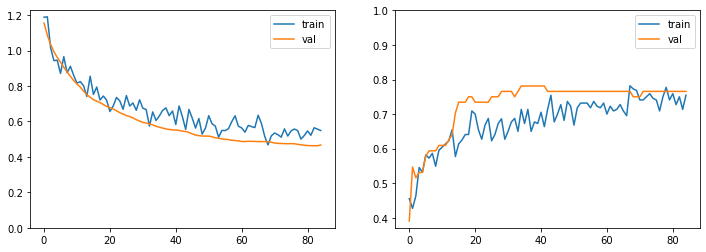

In [40]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 160, 160, 3) float32
(360,) int32
(91, 160, 160, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 27s 273ms/step - loss: 91.8078 - val_loss: 85.8780
Epoch 2/100
100/100 [==============================] - 24s 237ms/step - loss: 83.1373 - val_loss: 78.0432
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 75.7453 - val_loss: 77.1458
Epoch 4/100
100/100 [==============================] - 24s 238ms/step - loss: 67.6587 - val_loss: 78.5892
Epoch 5/100
100/100 [==============================] - 24s 238ms/step - loss: 66.3583 - val_loss: 78.9173
Epoch 6/100
100/100 [==============================] - 24s 238ms/step - loss: 63.4238 - val_loss: 81.3851
Epoch 7/100
100/100 [==============================] - 24s 239ms/step - loss: 57.0481 - val_loss: 81.7520
Epoch 8/100
100/100 [==============================] - 24s 236ms/step - loss: 53.0984 - val_loss: 81.7086
Epoch 9/100
100/100 [==============================] - 24s 241ms/step - loss: 51.2278 - val_loss: 82.5515
Epoch 10/100
100/100 [========================

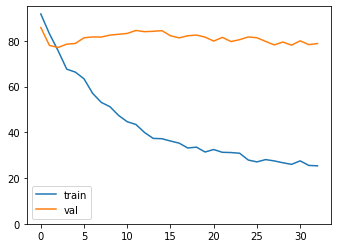

In [41]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
15/15 [==============================] - 5s 317ms/step - loss: 0.8064 - accuracy: 0.5729 - precision: 0.6134 - recall: 0.4250 - f1: 0.4912 - specificity: 0.7390 - negative_predictive_value: 0.5583 - matthews_correlation_coefficient: 0.1677 - equal_error_rate: 0.4555 - val_loss: 0.8730 - val_accuracy: 0.4792 - val_precision: 0.4908 - val_recall: 0.6456 - val_f1: 0.5568 - val_specificity: 0.2986 - val_negative_predictive_value: 0.4426 - val_matthews_correlation_coefficient: -0.0610 - val_equal_error_rate: 0.5904

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.06098, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_06-04_16_37.h5
Epoch 2/100
15/15 [==============================] - 2s 140ms/step - loss: 0.8016 - accuracy: 0.5403 - precision: 0.5641 - recall: 0.3587 - f1: 0.4324 - specificity: 0.7228 - negative_predictive_value: 0.5277 - matthews_correlation_coefficient: 0.0859 - equal_error_rate: 0.4745 - val_loss: 0.8715 - v

15/15 [==============================] - 2s 149ms/step - loss: 0.7217 - accuracy: 0.5805 - precision: 0.5906 - recall: 0.5693 - f1: 0.5693 - specificity: 0.5935 - negative_predictive_value: 0.5755 - matthews_correlation_coefficient: 0.1644 - equal_error_rate: 0.4345 - val_loss: 0.8027 - val_accuracy: 0.5208 - val_precision: 0.5142 - val_recall: 0.7251 - val_f1: 0.6011 - val_specificity: 0.2986 - val_negative_predictive_value: 0.5339 - val_matthews_correlation_coefficient: 0.0349 - val_equal_error_rate: 0.4990

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.05302
Epoch 15/100
15/15 [==============================] - 2s 154ms/step - loss: 0.7479 - accuracy: 0.5360 - precision: 0.5476 - recall: 0.4996 - f1: 0.5121 - specificity: 0.5616 - negative_predictive_value: 0.5246 - matthews_correlation_coefficient: 0.0666 - equal_error_rate: 0.4716 - val_loss: 0.8049 - val_accuracy: 0.5208 - val_precision: 0.5142 - val_recall: 0.7251 - val_f1: 0.6011 - val_specificity: 0.


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.05302
Epoch 28/100
15/15 [==============================] - 2s 147ms/step - loss: 0.7018 - accuracy: 0.5678 - precision: 0.5663 - recall: 0.4974 - f1: 0.5217 - specificity: 0.6362 - negative_predictive_value: 0.5637 - matthews_correlation_coefficient: 0.1317 - equal_error_rate: 0.4333 - val_loss: 0.7788 - val_accuracy: 0.5208 - val_precision: 0.5096 - val_recall: 0.6363 - val_f1: 0.5649 - val_specificity: 0.3952 - val_negative_predictive_value: 0.5407 - val_matthews_correlation_coefficient: 0.0406 - val_equal_error_rate: 0.4706

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.05302
Epoch 29/100
15/15 [==============================] - 2s 143ms/step - loss: 0.6948 - accuracy: 0.5720 - precision: 0.5860 - recall: 0.4957 - f1: 0.5302 - specificity: 0.6487 - negative_predictive_value: 0.5610 - matthews_correlation_coefficient: 0.1456 - equal_error_rate: 0.4113 - val_loss: 0.7752 - val_accurac

15/15 [==============================] - 2s 147ms/step - loss: 0.6697 - accuracy: 0.5911 - precision: 0.5850 - recall: 0.5460 - f1: 0.5597 - specificity: 0.6335 - negative_predictive_value: 0.5984 - matthews_correlation_coefficient: 0.1814 - equal_error_rate: 0.4076 - val_loss: 0.7666 - val_accuracy: 0.5208 - val_precision: 0.5238 - val_recall: 0.6632 - val_f1: 0.5833 - val_specificity: 0.3756 - val_negative_predictive_value: 0.5152 - val_matthews_correlation_coefficient: 0.0389 - val_equal_error_rate: 0.4584

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.06171
Epoch 42/100
15/15 [==============================] - 2s 150ms/step - loss: 0.6747 - accuracy: 0.5869 - precision: 0.6064 - recall: 0.4932 - f1: 0.5383 - specificity: 0.6653 - negative_predictive_value: 0.5679 - matthews_correlation_coefficient: 0.1663 - equal_error_rate: 0.4209 - val_loss: 0.7708 - val_accuracy: 0.5104 - val_precision: 0.5159 - val_recall: 0.6409 - val_f1: 0.5701 - val_specificity: 0.


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.06171
Epoch 55/100
15/15 [==============================] - 2s 149ms/step - loss: 0.6752 - accuracy: 0.6123 - precision: 0.6316 - recall: 0.5526 - f1: 0.5786 - specificity: 0.6868 - negative_predictive_value: 0.6076 - matthews_correlation_coefficient: 0.2393 - equal_error_rate: 0.3963 - val_loss: 0.7542 - val_accuracy: 0.5104 - val_precision: 0.5028 - val_recall: 0.5965 - val_f1: 0.5446 - val_specificity: 0.4148 - val_negative_predictive_value: 0.5177 - val_matthews_correlation_coefficient: 0.0158 - val_equal_error_rate: 0.4584

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.06171
Epoch 56/100
15/15 [==============================] - 2s 148ms/step - loss: 0.6719 - accuracy: 0.6081 - precision: 0.6394 - recall: 0.5802 - f1: 0.5945 - specificity: 0.6565 - negative_predictive_value: 0.5988 - matthews_correlation_coefficient: 0.2374 - equal_error_rate: 0.4006 - val_loss: 0.7456 - val_accurac

15/15 [==============================] - 2s 148ms/step - loss: 0.6385 - accuracy: 0.6314 - precision: 0.6747 - recall: 0.5580 - f1: 0.6045 - specificity: 0.7143 - negative_predictive_value: 0.6029 - matthews_correlation_coefficient: 0.2748 - equal_error_rate: 0.3458 - val_loss: 0.7436 - val_accuracy: 0.5000 - val_precision: 0.5079 - val_recall: 0.6012 - val_f1: 0.5491 - val_specificity: 0.3952 - val_negative_predictive_value: 0.4850 - val_matthews_correlation_coefficient: -0.0053 - val_equal_error_rate: 0.4584

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.06171
Epoch 69/100
15/15 [==============================] - 2s 149ms/step - loss: 0.6549 - accuracy: 0.6144 - precision: 0.6270 - recall: 0.5675 - f1: 0.5876 - specificity: 0.6673 - negative_predictive_value: 0.6055 - matthews_correlation_coefficient: 0.2335 - equal_error_rate: 0.3881 - val_loss: 0.7441 - val_accuracy: 0.5000 - val_precision: 0.5079 - val_recall: 0.6012 - val_f1: 0.5491 - val_specificity: 0

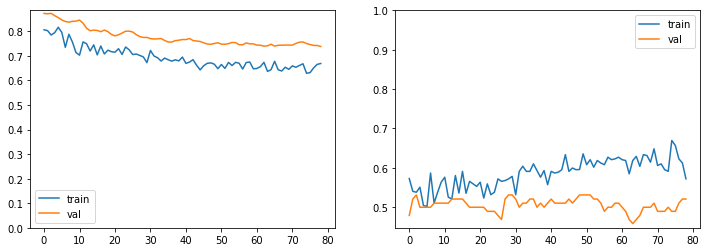

In [42]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 160, 160, 3) float32
(639,) int32
(161, 160, 160, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 277ms/step - loss: 87.7903 - val_loss: 68.0721
Epoch 2/100
100/100 [==============================] - 25s 248ms/step - loss: 73.0478 - val_loss: 77.8750
Epoch 3/100
100/100 [==============================] - 25s 249ms/step - loss: 64.2095 - val_loss: 82.0435
Epoch 4/100
100/100 [==============================] - 25s 248ms/step - loss: 60.2871 - val_loss: 84.5208
Epoch 5/100
100/100 [==============================] - 25s 248ms/step - loss: 58.6224 - val_loss: 85.9226
Epoch 6/100
100/100 [==============================] - 25s 248ms/step - loss: 56.5338 - val_loss: 86.5872
Epoch 7/100
100/100 [==============================] - 25s 248ms/step - loss: 52.2335 - val_loss: 87.3900
Epoch 8/100
100/100 [==============================] - 25s 248ms/step - loss: 50.7041 - val_loss: 86.5211
Epoch 9/100
100/100 [==============================] - 25s 248ms/step - loss: 54.3977 - val_loss: 86.5885
Epoch 10/100
100/100 [========================

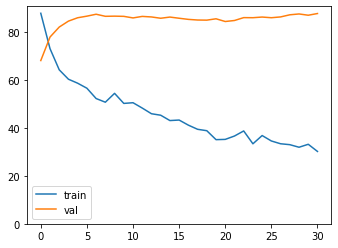

In [43]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
21/21 [==============================] - 6s 279ms/step - loss: 0.8198 - accuracy: 0.5327 - precision: 0.5390 - recall: 0.3468 - f1: 0.4114 - specificity: 0.7225 - negative_predictive_value: 0.5246 - matthews_correlation_coefficient: 0.0670 - equal_error_rate: 0.4705 - val_loss: 0.7179 - val_accuracy: 0.5312 - val_precision: 0.5213 - val_recall: 0.5990 - val_f1: 0.5520 - val_specificity: 0.4625 - val_negative_predictive_value: 0.5495 - val_matthews_correlation_coefficient: 0.0659 - val_equal_error_rate: 0.4757

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06586, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_06-04_35_25.h5
Epoch 2/100
21/21 [==============================] - 3s 155ms/step - loss: 0.7357 - accuracy: 0.5586 - precision: 0.5707 - recall: 0.5229 - f1: 0.5375 - specificity: 0.5991 - negative_predictive_value: 0.5533 - matthews_correlation_coefficient: 0.1229 - equal_error_rate: 0.4490 - val_loss: 0.70


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.22917
Epoch 14/100
21/21 [==============================] - 3s 155ms/step - loss: 0.6933 - accuracy: 0.6096 - precision: 0.6064 - recall: 0.6085 - f1: 0.6033 - specificity: 0.6101 - negative_predictive_value: 0.6106 - matthews_correlation_coefficient: 0.2177 - equal_error_rate: 0.3989 - val_loss: 0.7186 - val_accuracy: 0.5625 - val_precision: 0.5833 - val_recall: 0.4887 - val_f1: 0.5172 - val_specificity: 0.6510 - val_negative_predictive_value: 0.5617 - val_matthews_correlation_coefficient: 0.1422 - val_equal_error_rate: 0.4120

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22917
Epoch 15/100
21/21 [==============================] - 3s 153ms/step - loss: 0.6767 - accuracy: 0.6126 - precision: 0.6024 - recall: 0.6368 - f1: 0.6149 - specificity: 0.5874 - negative_predictive_value: 0.6217 - matthews_correlation_coefficient: 0.2241 - equal_error_rate: 0.3973 - val_loss: 0.7172 - val_accurac

21/21 [==============================] - 3s 151ms/step - loss: 0.6569 - accuracy: 0.6201 - precision: 0.6182 - recall: 0.5992 - f1: 0.6026 - specificity: 0.6381 - negative_predictive_value: 0.6208 - matthews_correlation_coefficient: 0.2381 - equal_error_rate: 0.3924 - val_loss: 0.6951 - val_accuracy: 0.5938 - val_precision: 0.6422 - val_recall: 0.5095 - val_f1: 0.5535 - val_specificity: 0.6907 - val_negative_predictive_value: 0.5793 - val_matthews_correlation_coefficient: 0.2102 - val_equal_error_rate: 0.3993

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.22917
Epoch 28/100
21/21 [==============================] - 3s 148ms/step - loss: 0.6483 - accuracy: 0.6171 - precision: 0.6203 - recall: 0.5946 - f1: 0.6024 - specificity: 0.6414 - negative_predictive_value: 0.6143 - matthews_correlation_coefficient: 0.2352 - equal_error_rate: 0.3836 - val_loss: 0.7018 - val_accuracy: 0.5750 - val_precision: 0.6139 - val_recall: 0.4730 - val_f1: 0.5207 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient improved from 0.22917 to 0.24122, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_06-04_35_25.h5
Epoch 41/100
21/21 [==============================] - 3s 148ms/step - loss: 0.6521 - accuracy: 0.6336 - precision: 0.6363 - recall: 0.6129 - f1: 0.6193 - specificity: 0.6534 - negative_predictive_value: 0.6311 - matthews_correlation_coefficient: 0.2668 - equal_error_rate: 0.3570 - val_loss: 0.6947 - val_accuracy: 0.6062 - val_precision: 0.6701 - val_recall: 0.4730 - val_f1: 0.5372 - val_specificity: 0.7536 - val_negative_predictive_value: 0.5889 - val_matthews_correlation_coefficient: 0.2412 - val_equal_error_rate: 0.3993

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.24122
Epoch 42/100
21/21 [==============================] - 3s 150ms/step - loss: 0.6531 - accuracy: 0.6306 - precision: 0.6415 - recall: 0.5923 - f1: 0.6092 - specificity: 0.6729 - negative_predictive_value: 0.6245 -

21/21 [==============================] - 3s 148ms/step - loss: 0.6484 - accuracy: 0.6366 - precision: 0.6481 - recall: 0.6162 - f1: 0.6222 - specificity: 0.6708 - negative_predictive_value: 0.6380 - matthews_correlation_coefficient: 0.2865 - equal_error_rate: 0.3581 - val_loss: 0.6955 - val_accuracy: 0.6062 - val_precision: 0.6683 - val_recall: 0.4716 - val_f1: 0.5398 - val_specificity: 0.7536 - val_negative_predictive_value: 0.5870 - val_matthews_correlation_coefficient: 0.2392 - val_equal_error_rate: 0.3868

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.24127
Epoch 55/100
21/21 [==============================] - 3s 148ms/step - loss: 0.6534 - accuracy: 0.6456 - precision: 0.6473 - recall: 0.6301 - f1: 0.6328 - specificity: 0.6648 - negative_predictive_value: 0.6458 - matthews_correlation_coefficient: 0.2939 - equal_error_rate: 0.3647 - val_loss: 0.6926 - val_accuracy: 0.5938 - val_precision: 0.6575 - val_recall: 0.4494 - val_f1: 0.5170 - val_specificity: 0.

21/21 [==============================] - 3s 150ms/step - loss: 0.6533 - accuracy: 0.6503 - precision: 0.6667 - recall: 0.6237 - f1: 0.6400 - specificity: 0.6829 - negative_predictive_value: 0.6385 - matthews_correlation_coefficient: 0.3059 - equal_error_rate: 0.3360 - val_loss: 0.6869 - val_accuracy: 0.6062 - val_precision: 0.6688 - val_recall: 0.4730 - val_f1: 0.5398 - val_specificity: 0.7536 - val_negative_predictive_value: 0.5881 - val_matthews_correlation_coefficient: 0.2406 - val_equal_error_rate: 0.3868

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.26351
Epoch 68/100
21/21 [==============================] - 3s 151ms/step - loss: 0.6240 - accuracy: 0.6607 - precision: 0.6771 - recall: 0.6222 - f1: 0.6422 - specificity: 0.7020 - negative_predictive_value: 0.6483 - matthews_correlation_coefficient: 0.3246 - equal_error_rate: 0.3362 - val_loss: 0.6913 - val_accuracy: 0.6062 - val_precision: 0.6688 - val_recall: 0.4730 - val_f1: 0.5398 - val_specificity: 0.


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.26351
Epoch 81/100
21/21 [==============================] - 3s 144ms/step - loss: 0.6387 - accuracy: 0.6547 - precision: 0.6738 - recall: 0.6096 - f1: 0.6330 - specificity: 0.7068 - negative_predictive_value: 0.6439 - matthews_correlation_coefficient: 0.3169 - equal_error_rate: 0.3321 - val_loss: 0.6904 - val_accuracy: 0.6000 - val_precision: 0.6641 - val_recall: 0.4619 - val_f1: 0.5271 - val_specificity: 0.7536 - val_negative_predictive_value: 0.5841 - val_matthews_correlation_coefficient: 0.2302 - val_equal_error_rate: 0.3868

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.26351
Epoch 82/100
21/21 [==============================] - 3s 149ms/step - loss: 0.6338 - accuracy: 0.6712 - precision: 0.6656 - recall: 0.6559 - f1: 0.6563 - specificity: 0.6888 - negative_predictive_value: 0.6791 - matthews_correlation_coefficient: 0.3447 - equal_error_rate: 0.3304 - val_loss: 0.6869 - val_accurac

21/21 [==============================] - 3s 147ms/step - loss: 0.6441 - accuracy: 0.6502 - precision: 0.6642 - recall: 0.6188 - f1: 0.6338 - specificity: 0.6841 - negative_predictive_value: 0.6410 - matthews_correlation_coefficient: 0.3039 - equal_error_rate: 0.3482 - val_loss: 0.6916 - val_accuracy: 0.6000 - val_precision: 0.6641 - val_recall: 0.4619 - val_f1: 0.5271 - val_specificity: 0.7536 - val_negative_predictive_value: 0.5841 - val_matthews_correlation_coefficient: 0.2302 - val_equal_error_rate: 0.3812

Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.26351
Epoch 95/100
21/21 [==============================] - 3s 149ms/step - loss: 0.6339 - accuracy: 0.6607 - precision: 0.6831 - recall: 0.6240 - f1: 0.6455 - specificity: 0.7033 - negative_predictive_value: 0.6453 - matthews_correlation_coefficient: 0.3277 - equal_error_rate: 0.3417 - val_loss: 0.6845 - val_accuracy: 0.6000 - val_precision: 0.6616 - val_recall: 0.4619 - val_f1: 0.5290 - val_specificity: 0.

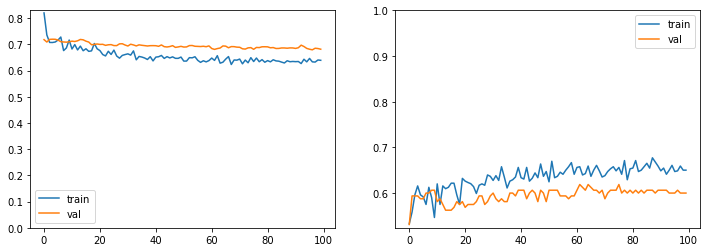

In [44]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 160, 160, 3) float32
(435,) int32
(110, 160, 160, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 279ms/step - loss: 96.2699 - val_loss: 89.3662
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 87.5249 - val_loss: 89.8027
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 81.1708 - val_loss: 88.6143
Epoch 4/100
100/100 [==============================] - 25s 247ms/step - loss: 76.9929 - val_loss: 88.4984
Epoch 5/100
100/100 [==============================] - 25s 246ms/step - loss: 73.7921 - val_loss: 87.7508
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 68.9577 - val_loss: 86.5838
Epoch 7/100
100/100 [==============================] - 25s 247ms/step - loss: 66.6436 - val_loss: 89.5911
Epoch 8/100
100/100 [==============================] - 25s 247ms/step - loss: 61.2647 - val_loss: 90.3305
Epoch 9/100
100/100 [==============================] - 25s 248ms/step - loss: 59.0095 - val_loss: 89.1298
Epoch 10/100
100/100 [========================

100/100 [==============================] - 25s 248ms/step - loss: 23.0760 - val_loss: 82.6180
Epoch 78/100
100/100 [==============================] - 25s 248ms/step - loss: 22.0667 - val_loss: 84.2147
Epoch 79/100
100/100 [==============================] - 25s 247ms/step - loss: 22.0158 - val_loss: 85.0484
Epoch 80/100
100/100 [==============================] - 25s 247ms/step - loss: 24.7289 - val_loss: 85.2659
Epoch 81/100
100/100 [==============================] - 25s 247ms/step - loss: 21.6757 - val_loss: 85.0250
Epoch 82/100
100/100 [==============================] - 25s 247ms/step - loss: 23.0742 - val_loss: 85.5604
Epoch 83/100
100/100 [==============================] - 25s 247ms/step - loss: 23.2771 - val_loss: 84.2032
Epoch 84/100
100/100 [==============================] - 25s 247ms/step - loss: 23.4806 - val_loss: 84.2414
Epoch 85/100
100/100 [==============================] - 25s 247ms/step - loss: 22.1412 - val_loss: 84.9598
Epoch 86/100
100/100 [============================

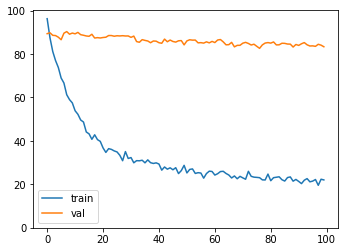

In [45]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
16/16 [==============================] - 5s 320ms/step - loss: 0.9953 - accuracy: 0.4980 - precision: 0.4860 - recall: 0.3074 - f1: 0.3656 - specificity: 0.6892 - negative_predictive_value: 0.4997 - matthews_correlation_coefficient: -0.0082 - equal_error_rate: 0.5156 - val_loss: 0.8452 - val_accuracy: 0.5312 - val_precision: 0.5382 - val_recall: 0.2420 - val_f1: 0.3326 - val_specificity: 0.8067 - val_negative_predictive_value: 0.5226 - val_matthews_correlation_coefficient: 0.0545 - val_equal_error_rate: 0.4976

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05446, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_06-05_24_48.h5
Epoch 2/100
16/16 [==============================] - 2s 154ms/step - loss: 0.8998 - accuracy: 0.5637 - precision: 0.5852 - recall: 0.4394 - f1: 0.4954 - specificity: 0.6832 - negative_predictive_value: 0.5457 - matthews_correlation_coefficient: 0.1263 - equal_error_rate: 0.4509 - val_loss: 0.8131 - v

16/16 [==============================] - 2s 131ms/step - loss: 0.7741 - accuracy: 0.6016 - precision: 0.6657 - recall: 0.4583 - f1: 0.5280 - specificity: 0.7590 - negative_predictive_value: 0.5777 - matthews_correlation_coefficient: 0.2295 - equal_error_rate: 0.4193 - val_loss: 0.6792 - val_accuracy: 0.6328 - val_precision: 0.6919 - val_recall: 0.4225 - val_f1: 0.5215 - val_specificity: 0.8296 - val_negative_predictive_value: 0.5978 - val_matthews_correlation_coefficient: 0.2696 - val_equal_error_rate: 0.4212

Epoch 00013: val_matthews_correlation_coefficient improved from 0.25150 to 0.26960, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_06-05_24_48.h5
Epoch 14/100
16/16 [==============================] - 2s 135ms/step - loss: 0.7407 - accuracy: 0.6295 - precision: 0.6663 - recall: 0.5128 - f1: 0.5712 - specificity: 0.7498 - negative_predictive_value: 0.6073 - matthews_correlation_coefficient: 0.2675 - equal_error_rate: 0.3834 - val_loss: 0.6710 - val_accura

16/16 [==============================] - 2s 141ms/step - loss: 0.6897 - accuracy: 0.6215 - precision: 0.6469 - recall: 0.5211 - f1: 0.5680 - specificity: 0.7305 - negative_predictive_value: 0.6115 - matthews_correlation_coefficient: 0.2547 - equal_error_rate: 0.3537 - val_loss: 0.6081 - val_accuracy: 0.6250 - val_precision: 0.6532 - val_recall: 0.4507 - val_f1: 0.5319 - val_specificity: 0.7876 - val_negative_predictive_value: 0.5989 - val_matthews_correlation_coefficient: 0.2448 - val_equal_error_rate: 0.3742

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.29598
Epoch 27/100
16/16 [==============================] - 2s 139ms/step - loss: 0.6907 - accuracy: 0.6434 - precision: 0.6768 - recall: 0.5498 - f1: 0.5958 - specificity: 0.7435 - negative_predictive_value: 0.6191 - matthews_correlation_coefficient: 0.2944 - equal_error_rate: 0.3749 - val_loss: 0.5999 - val_accuracy: 0.6250 - val_precision: 0.6532 - val_recall: 0.4507 - val_f1: 0.5319 - val_specificity: 0.


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.29598
Epoch 40/100
16/16 [==============================] - 2s 141ms/step - loss: 0.6124 - accuracy: 0.6873 - precision: 0.7519 - recall: 0.5415 - f1: 0.6187 - specificity: 0.8341 - negative_predictive_value: 0.6567 - matthews_correlation_coefficient: 0.3908 - equal_error_rate: 0.3181 - val_loss: 0.5811 - val_accuracy: 0.6406 - val_precision: 0.6810 - val_recall: 0.4663 - val_f1: 0.5527 - val_specificity: 0.8015 - val_negative_predictive_value: 0.6088 - val_matthews_correlation_coefficient: 0.2782 - val_equal_error_rate: 0.3439

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.29598
Epoch 41/100
16/16 [==============================] - 2s 139ms/step - loss: 0.6121 - accuracy: 0.6972 - precision: 0.7877 - recall: 0.5572 - f1: 0.6425 - specificity: 0.8598 - negative_predictive_value: 0.6562 - matthews_correlation_coefficient: 0.4300 - equal_error_rate: 0.2972 - val_loss: 0.5830 - val_accurac

16/16 [==============================] - 2s 141ms/step - loss: 0.5899 - accuracy: 0.7032 - precision: 0.7796 - recall: 0.5867 - f1: 0.6606 - specificity: 0.8330 - negative_predictive_value: 0.6624 - matthews_correlation_coefficient: 0.4299 - equal_error_rate: 0.2828 - val_loss: 0.5756 - val_accuracy: 0.6406 - val_precision: 0.6692 - val_recall: 0.5011 - val_f1: 0.5723 - val_specificity: 0.7720 - val_negative_predictive_value: 0.6141 - val_matthews_correlation_coefficient: 0.2780 - val_equal_error_rate: 0.3666

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.32903
Epoch 54/100
16/16 [==============================] - 2s 139ms/step - loss: 0.6195 - accuracy: 0.6673 - precision: 0.7437 - recall: 0.5409 - f1: 0.6164 - specificity: 0.8059 - negative_predictive_value: 0.6307 - matthews_correlation_coefficient: 0.3595 - equal_error_rate: 0.3278 - val_loss: 0.5651 - val_accuracy: 0.6250 - val_precision: 0.6512 - val_recall: 0.4520 - val_f1: 0.5310 - val_specificity: 0.


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.32903
Epoch 67/100
16/16 [==============================] - 2s 137ms/step - loss: 0.5834 - accuracy: 0.7331 - precision: 0.8024 - recall: 0.6024 - f1: 0.6803 - specificity: 0.8609 - negative_predictive_value: 0.6862 - matthews_correlation_coefficient: 0.4751 - equal_error_rate: 0.2939 - val_loss: 0.5534 - val_accuracy: 0.6328 - val_precision: 0.6643 - val_recall: 0.4663 - val_f1: 0.5473 - val_specificity: 0.7876 - val_negative_predictive_value: 0.6048 - val_matthews_correlation_coefficient: 0.2611 - val_equal_error_rate: 0.3439

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.32903
Epoch 68/100
16/16 [==============================] - 2s 135ms/step - loss: 0.5754 - accuracy: 0.7291 - precision: 0.8371 - recall: 0.5712 - f1: 0.6690 - specificity: 0.8925 - negative_predictive_value: 0.6717 - matthews_correlation_coefficient: 0.4847 - equal_error_rate: 0.2583 - val_loss: 0.5560 - val_accurac

16/16 [==============================] - 2s 136ms/step - loss: 0.5715 - accuracy: 0.7331 - precision: 0.8196 - recall: 0.5922 - f1: 0.6817 - specificity: 0.8750 - negative_predictive_value: 0.6810 - matthews_correlation_coefficient: 0.4831 - equal_error_rate: 0.2900 - val_loss: 0.5520 - val_accuracy: 0.6484 - val_precision: 0.6825 - val_recall: 0.5011 - val_f1: 0.5769 - val_specificity: 0.7876 - val_negative_predictive_value: 0.6194 - val_matthews_correlation_coefficient: 0.2951 - val_equal_error_rate: 0.3600

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.32903
Epoch 81/100
16/16 [==============================] - 2s 138ms/step - loss: 0.5496 - accuracy: 0.7470 - precision: 0.8504 - recall: 0.6261 - f1: 0.7111 - specificity: 0.8842 - negative_predictive_value: 0.6951 - matthews_correlation_coefficient: 0.5265 - equal_error_rate: 0.2474 - val_loss: 0.5535 - val_accuracy: 0.6484 - val_precision: 0.6825 - val_recall: 0.5011 - val_f1: 0.5769 - val_specificity: 0.

Restoring model weights from the end of the best epoch

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.32903
Epoch 00093: early stopping

   Final Accuracy:  63.64%
  Final Precision:  81.40%
     Final Recall:  52.24%
  Final F-measure:  63.64%
Final Specificity:  81.40%
        Final NPV:  52.24%
        Final MCC:  33.63%

[[35  8]
 [32 35]]
              precision    recall  f1-score   support

           0       0.52      0.81      0.64        43
           1       0.81      0.52      0.64        67

    accuracy                           0.64       110
   macro avg       0.67      0.67      0.64       110
weighted avg       0.70      0.64      0.64       110



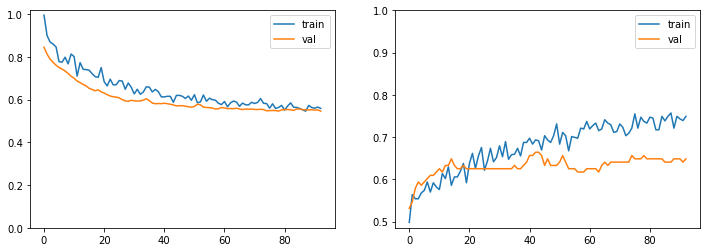

In [46]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 28s 281ms/step - loss: 95.9504 - val_loss: 84.5889
Epoch 2/100
100/100 [==============================] - 25s 246ms/step - loss: 83.2143 - val_loss: 77.7004
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 79.7569 - val_loss: 74.9708
Epoch 4/100
100/100 [==============================] - 25s 246ms/step - loss: 77.2803 - val_loss: 72.7008
Epoch 5/100
100/100 [==============================] - 25s 246ms/step - loss: 72.5998 - val_loss: 71.4327
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 69.4375 - val_loss: 70.1970
Epoch 7/100
100/100 [==============================] - 25s 247ms/step - loss: 66.0056 - val_loss: 71.9927
Epoch 8/100
100/100 [==============================] - 25s 245ms/step - loss: 62.6745 - val_loss: 72.6069
Epoch 9/100
100/100 [==============================] - 25s 245ms/step - loss: 60.3376 - val_loss: 71.9704
Epoch 10/100
100/100 [========================

100/100 [==============================] - 25s 247ms/step - loss: 30.1144 - val_loss: 61.2711
Epoch 78/100
100/100 [==============================] - 25s 246ms/step - loss: 30.2885 - val_loss: 60.3400
Epoch 79/100
100/100 [==============================] - 25s 246ms/step - loss: 26.8576 - val_loss: 60.5110
Epoch 80/100
100/100 [==============================] - 25s 245ms/step - loss: 26.9610 - val_loss: 60.8760
Epoch 81/100
100/100 [==============================] - 25s 247ms/step - loss: 27.5023 - val_loss: 62.4396
Epoch 82/100
100/100 [==============================] - 25s 246ms/step - loss: 29.8890 - val_loss: 62.8050
Epoch 83/100
100/100 [==============================] - 25s 246ms/step - loss: 28.8298 - val_loss: 62.0069
Epoch 84/100
100/100 [==============================] - 25s 246ms/step - loss: 29.9929 - val_loss: 60.2162
Epoch 85/100
100/100 [==============================] - 25s 246ms/step - loss: 28.9050 - val_loss: 59.8294
Epoch 86/100
100/100 [============================

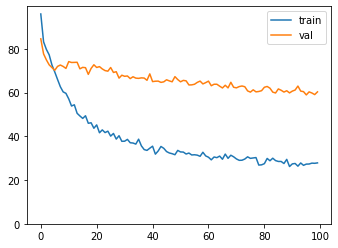

In [47]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
45/45 [==============================] - 9s 208ms/step - loss: 0.8869 - accuracy: 0.5472 - precision: 0.5513 - recall: 0.4135 - f1: 0.4641 - specificity: 0.6772 - negative_predictive_value: 0.5389 - matthews_correlation_coefficient: 0.0907 - equal_error_rate: 0.4682 - val_loss: 0.6870 - val_accuracy: 0.6477 - val_precision: 0.7907 - val_recall: 0.3880 - val_f1: 0.5145 - val_specificity: 0.8987 - val_negative_predictive_value: 0.5988 - val_matthews_correlation_coefficient: 0.3326 - val_equal_error_rate: 0.3950

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33261, saving model to ../../models/siamese_networks/hat_cap_2020_06_06-06_13_31.h5
Epoch 2/100
45/45 [==============================] - 6s 140ms/step - loss: 0.8067 - accuracy: 0.5750 - precision: 0.5893 - recall: 0.4964 - f1: 0.5316 - specificity: 0.6567 - negative_predictive_value: 0.5647 - matthews_correlation_coefficient: 0.1535 - equal_error_rate: 0.4252 - val_loss: 0.6509 - val_accuracy: 


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.39836
Epoch 14/100
45/45 [==============================] - 6s 141ms/step - loss: 0.6579 - accuracy: 0.6326 - precision: 0.6917 - recall: 0.5069 - f1: 0.5754 - specificity: 0.7640 - negative_predictive_value: 0.6036 - matthews_correlation_coefficient: 0.2825 - equal_error_rate: 0.3815 - val_loss: 0.6181 - val_accuracy: 0.6705 - val_precision: 0.8598 - val_recall: 0.4059 - val_f1: 0.5425 - val_specificity: 0.9280 - val_negative_predictive_value: 0.6130 - val_matthews_correlation_coefficient: 0.3939 - val_equal_error_rate: 0.3279

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39836
Epoch 15/100
45/45 [==============================] - 6s 140ms/step - loss: 0.6444 - accuracy: 0.6438 - precision: 0.6951 - recall: 0.5265 - f1: 0.5881 - specificity: 0.7687 - negative_predictive_value: 0.6173 - matthews_correlation_coefficient: 0.3031 - equal_error_rate: 0.3632 - val_loss: 0.6146 - val_accurac

45/45 [==============================] - 6s 142ms/step - loss: 0.6144 - accuracy: 0.6667 - precision: 0.7595 - recall: 0.4934 - f1: 0.5913 - specificity: 0.8461 - negative_predictive_value: 0.6229 - matthews_correlation_coefficient: 0.3598 - equal_error_rate: 0.3573 - val_loss: 0.5839 - val_accuracy: 0.6705 - val_precision: 0.8662 - val_recall: 0.3997 - val_f1: 0.5403 - val_specificity: 0.9337 - val_negative_predictive_value: 0.6120 - val_matthews_correlation_coefficient: 0.3968 - val_equal_error_rate: 0.3017

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.41963
Epoch 28/100
45/45 [==============================] - 6s 142ms/step - loss: 0.6140 - accuracy: 0.6549 - precision: 0.7282 - recall: 0.4963 - f1: 0.5810 - specificity: 0.8182 - negative_predictive_value: 0.6181 - matthews_correlation_coefficient: 0.3295 - equal_error_rate: 0.3470 - val_loss: 0.5845 - val_accuracy: 0.6705 - val_precision: 0.8766 - val_recall: 0.3898 - val_f1: 0.5343 - val_specificity: 0.

45/45 [==============================] - 6s 140ms/step - loss: 0.5913 - accuracy: 0.6764 - precision: 0.7771 - recall: 0.4978 - f1: 0.5957 - specificity: 0.8618 - negative_predictive_value: 0.6318 - matthews_correlation_coefficient: 0.3826 - equal_error_rate: 0.3256 - val_loss: 0.5720 - val_accuracy: 0.6761 - val_precision: 0.9136 - val_recall: 0.3804 - val_f1: 0.5320 - val_specificity: 0.9675 - val_negative_predictive_value: 0.6130 - val_matthews_correlation_coefficient: 0.4260 - val_equal_error_rate: 0.2843

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.44039
Epoch 41/100
45/45 [==============================] - 6s 141ms/step - loss: 0.6047 - accuracy: 0.6812 - precision: 0.7872 - recall: 0.5047 - f1: 0.6065 - specificity: 0.8622 - negative_predictive_value: 0.6323 - matthews_correlation_coefficient: 0.3916 - equal_error_rate: 0.3384 - val_loss: 0.5640 - val_accuracy: 0.6875 - val_precision: 0.8925 - val_recall: 0.4195 - val_f1: 0.5658 - val_specificity: 0.

45/45 [==============================] - 6s 139ms/step - loss: 0.5812 - accuracy: 0.7021 - precision: 0.8219 - recall: 0.5226 - f1: 0.6296 - specificity: 0.8827 - negative_predictive_value: 0.6471 - matthews_correlation_coefficient: 0.4347 - equal_error_rate: 0.3080 - val_loss: 0.5657 - val_accuracy: 0.6989 - val_precision: 0.9199 - val_recall: 0.4239 - val_f1: 0.5758 - val_specificity: 0.9675 - val_negative_predictive_value: 0.6303 - val_matthews_correlation_coefficient: 0.4622 - val_equal_error_rate: 0.2685

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.46722
Epoch 54/100
45/45 [==============================] - 6s 138ms/step - loss: 0.5900 - accuracy: 0.6792 - precision: 0.7738 - recall: 0.5021 - f1: 0.6018 - specificity: 0.8605 - negative_predictive_value: 0.6327 - matthews_correlation_coefficient: 0.3834 - equal_error_rate: 0.3233 - val_loss: 0.5627 - val_accuracy: 0.6903 - val_precision: 0.8865 - val_recall: 0.4273 - val_f1: 0.5725 - val_specificity: 0.

45/45 [==============================] - 6s 141ms/step - loss: 0.5845 - accuracy: 0.6722 - precision: 0.7638 - recall: 0.5029 - f1: 0.5966 - specificity: 0.8466 - negative_predictive_value: 0.6288 - matthews_correlation_coefficient: 0.3698 - equal_error_rate: 0.3302 - val_loss: 0.5396 - val_accuracy: 0.7131 - val_precision: 0.8934 - val_recall: 0.4738 - val_f1: 0.6120 - val_specificity: 0.9438 - val_negative_predictive_value: 0.6470 - val_matthews_correlation_coefficient: 0.4726 - val_equal_error_rate: 0.2708

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.48407
Epoch 67/100
45/45 [==============================] - 6s 142ms/step - loss: 0.5916 - accuracy: 0.6757 - precision: 0.7512 - recall: 0.5264 - f1: 0.6121 - specificity: 0.8260 - negative_predictive_value: 0.6333 - matthews_correlation_coefficient: 0.3678 - equal_error_rate: 0.3426 - val_loss: 0.5469 - val_accuracy: 0.7017 - val_precision: 0.9207 - val_recall: 0.4300 - val_f1: 0.5810 - val_specificity: 0.


Epoch 00079: val_matthews_correlation_coefficient improved from 0.48407 to 0.49110, saving model to ../../models/siamese_networks/hat_cap_2020_06_06-06_13_31.h5
Epoch 80/100
45/45 [==============================] - 6s 140ms/step - loss: 0.5770 - accuracy: 0.6889 - precision: 0.7833 - recall: 0.5232 - f1: 0.6194 - specificity: 0.8512 - negative_predictive_value: 0.6401 - matthews_correlation_coefficient: 0.3971 - equal_error_rate: 0.3285 - val_loss: 0.5396 - val_accuracy: 0.7102 - val_precision: 0.9179 - val_recall: 0.4513 - val_f1: 0.5991 - val_specificity: 0.9618 - val_negative_predictive_value: 0.6410 - val_matthews_correlation_coefficient: 0.4783 - val_equal_error_rate: 0.2600

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.49110
Epoch 81/100
45/45 [==============================] - 6s 142ms/step - loss: 0.5790 - accuracy: 0.6854 - precision: 0.7625 - recall: 0.5404 - f1: 0.6233 - specificity: 0.8323 - negative_predictive_value: 0.6446 - matthews_correlati

45/45 [==============================] - 6s 141ms/step - loss: 0.5761 - accuracy: 0.6938 - precision: 0.7732 - recall: 0.5497 - f1: 0.6356 - specificity: 0.8374 - negative_predictive_value: 0.6479 - matthews_correlation_coefficient: 0.4031 - equal_error_rate: 0.3134 - val_loss: 0.5311 - val_accuracy: 0.7216 - val_precision: 0.9173 - val_recall: 0.4717 - val_f1: 0.6170 - val_specificity: 0.9605 - val_negative_predictive_value: 0.6505 - val_matthews_correlation_coefficient: 0.4928 - val_equal_error_rate: 0.2678

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.49763
Epoch 94/100
45/45 [==============================] - 6s 141ms/step - loss: 0.5709 - accuracy: 0.6875 - precision: 0.7565 - recall: 0.5537 - f1: 0.6306 - specificity: 0.8207 - negative_predictive_value: 0.6465 - matthews_correlation_coefficient: 0.3877 - equal_error_rate: 0.3171 - val_loss: 0.5300 - val_accuracy: 0.7216 - val_precision: 0.9173 - val_recall: 0.4717 - val_f1: 0.6170 - val_specificity: 0.

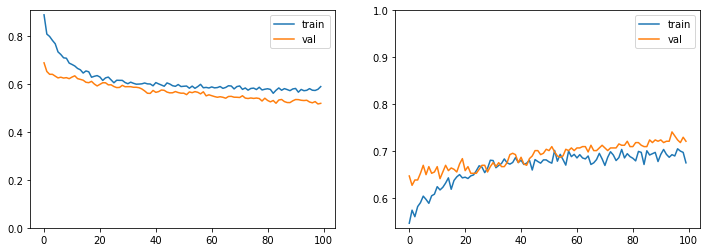

In [48]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 160, 160, 3) float32
(566,) int32
(142, 160, 160, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 288ms/step - loss: 75.3913 - val_loss: 64.4520
Epoch 2/100
100/100 [==============================] - 25s 251ms/step - loss: 47.4125 - val_loss: 69.7564
Epoch 3/100
100/100 [==============================] - 25s 252ms/step - loss: 36.0020 - val_loss: 66.9326
Epoch 4/100
100/100 [==============================] - 25s 252ms/step - loss: 27.8688 - val_loss: 67.7155
Epoch 5/100
100/100 [==============================] - 25s 251ms/step - loss: 20.9948 - val_loss: 67.7690
Epoch 6/100
100/100 [==============================] - 25s 252ms/step - loss: 17.4923 - val_loss: 69.1802
Epoch 7/100
100/100 [==============================] - 25s 251ms/step - loss: 14.9291 - val_loss: 70.8138
Epoch 8/100
100/100 [==============================] - 25s 252ms/step - loss: 13.7483 - val_loss: 71.7202
Epoch 9/100
100/100 [==============================] - 25s 251ms/step - loss: 12.6230 - val_loss: 73.4617
Epoch 10/100
100/100 [========================

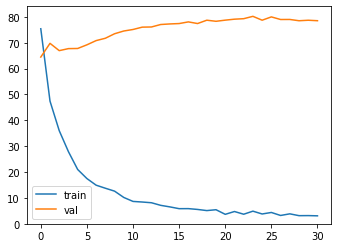

In [49]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
17/17 [==============================] - 6s 371ms/step - loss: 0.7827 - accuracy: 0.5055 - precision: 0.5116 - recall: 0.4797 - f1: 0.4854 - specificity: 0.5377 - negative_predictive_value: 0.5029 - matthews_correlation_coefficient: 0.0159 - equal_error_rate: 0.4834 - val_loss: 0.7513 - val_accuracy: 0.4766 - val_precision: 0.4781 - val_recall: 0.4244 - val_f1: 0.4453 - val_specificity: 0.5229 - val_negative_predictive_value: 0.4640 - val_matthews_correlation_coefficient: -0.0555 - val_equal_error_rate: 0.5098

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.05546, saving model to ../../models/siamese_networks/veil_over_face_2020_06_06-06_40_34.h5
Epoch 2/100
17/17 [==============================] - 3s 156ms/step - loss: 0.7901 - accuracy: 0.5225 - precision: 0.5342 - recall: 0.5014 - f1: 0.5095 - specificity: 0.5409 - negative_predictive_value: 0.5089 - matthews_correlation_coefficient: 0.0427 - equal_error_rate: 0.4798 - val_loss: 0.7388 - val_a

17/17 [==============================] - 2s 142ms/step - loss: 0.6143 - accuracy: 0.6442 - precision: 0.6884 - recall: 0.5334 - f1: 0.5904 - specificity: 0.7637 - negative_predictive_value: 0.6199 - matthews_correlation_coefficient: 0.3022 - equal_error_rate: 0.3539 - val_loss: 0.6621 - val_accuracy: 0.6875 - val_precision: 0.7604 - val_recall: 0.5520 - val_f1: 0.6338 - val_specificity: 0.8187 - val_negative_predictive_value: 0.6383 - val_matthews_correlation_coefficient: 0.3830 - val_equal_error_rate: 0.3289

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.38305
Epoch 14/100
17/17 [==============================] - 2s 144ms/step - loss: 0.6166 - accuracy: 0.6667 - precision: 0.7173 - recall: 0.5731 - f1: 0.6267 - specificity: 0.7685 - negative_predictive_value: 0.6408 - matthews_correlation_coefficient: 0.3496 - equal_error_rate: 0.3299 - val_loss: 0.6577 - val_accuracy: 0.6875 - val_precision: 0.7604 - val_recall: 0.5520 - val_f1: 0.6338 - val_specificity: 0.


Epoch 00025: val_matthews_correlation_coefficient improved from 0.52001 to 0.52989, saving model to ../../models/siamese_networks/veil_over_face_2020_06_06-06_40_34.h5
Epoch 26/100
17/17 [==============================] - 2s 143ms/step - loss: 0.6237 - accuracy: 0.6742 - precision: 0.7110 - recall: 0.5935 - f1: 0.6382 - specificity: 0.7603 - negative_predictive_value: 0.6487 - matthews_correlation_coefficient: 0.3566 - equal_error_rate: 0.3186 - val_loss: 0.5961 - val_accuracy: 0.7656 - val_precision: 0.8794 - val_recall: 0.6056 - val_f1: 0.7159 - val_specificity: 0.9185 - val_negative_predictive_value: 0.6927 - val_matthews_correlation_coefficient: 0.5462 - val_equal_error_rate: 0.2344

Epoch 00026: val_matthews_correlation_coefficient improved from 0.52989 to 0.54620, saving model to ../../models/siamese_networks/veil_over_face_2020_06_06-06_40_34.h5
Epoch 27/100
17/17 [==============================] - 3s 148ms/step - loss: 0.5762 - accuracy: 0.7191 - precision: 0.7611 - recall: 0.

17/17 [==============================] - 2s 146ms/step - loss: 0.5926 - accuracy: 0.7060 - precision: 0.7615 - recall: 0.6297 - f1: 0.6780 - specificity: 0.7994 - negative_predictive_value: 0.6731 - matthews_correlation_coefficient: 0.4316 - equal_error_rate: 0.2706 - val_loss: 0.5607 - val_accuracy: 0.8047 - val_precision: 0.9008 - val_recall: 0.6992 - val_f1: 0.7828 - val_specificity: 0.9177 - val_negative_predictive_value: 0.7401 - val_matthews_correlation_coefficient: 0.6280 - val_equal_error_rate: 0.1865

Epoch 00038: val_matthews_correlation_coefficient improved from 0.59227 to 0.62797, saving model to ../../models/siamese_networks/veil_over_face_2020_06_06-06_40_34.h5
Epoch 39/100
17/17 [==============================] - 2s 144ms/step - loss: 0.5644 - accuracy: 0.7154 - precision: 0.7770 - recall: 0.6334 - f1: 0.6904 - specificity: 0.8090 - negative_predictive_value: 0.6770 - matthews_correlation_coefficient: 0.4479 - equal_error_rate: 0.2646 - val_loss: 0.5596 - val_accuracy: 0

17/17 [==============================] - 2s 141ms/step - loss: 0.5724 - accuracy: 0.7191 - precision: 0.7722 - recall: 0.6255 - f1: 0.6830 - specificity: 0.8257 - negative_predictive_value: 0.6854 - matthews_correlation_coefficient: 0.4542 - equal_error_rate: 0.2818 - val_loss: 0.5416 - val_accuracy: 0.7734 - val_precision: 0.8976 - val_recall: 0.6042 - val_f1: 0.7192 - val_specificity: 0.9324 - val_negative_predictive_value: 0.6971 - val_matthews_correlation_coefficient: 0.5630 - val_equal_error_rate: 0.1803

Epoch 00051: val_matthews_correlation_coefficient did not improve from 0.62797
Epoch 52/100
17/17 [==============================] - 2s 145ms/step - loss: 0.5630 - accuracy: 0.7341 - precision: 0.7471 - recall: 0.6887 - f1: 0.7083 - specificity: 0.7787 - negative_predictive_value: 0.7239 - matthews_correlation_coefficient: 0.4691 - equal_error_rate: 0.2713 - val_loss: 0.5418 - val_accuracy: 0.7812 - val_precision: 0.9021 - val_recall: 0.6235 - val_f1: 0.7359 - val_specificity: 0.

17/17 [==============================] - 2s 143ms/step - loss: 0.5461 - accuracy: 0.7472 - precision: 0.8114 - recall: 0.6430 - f1: 0.7100 - specificity: 0.8546 - negative_predictive_value: 0.7023 - matthews_correlation_coefficient: 0.5050 - equal_error_rate: 0.2667 - val_loss: 0.5194 - val_accuracy: 0.8047 - val_precision: 0.9092 - val_recall: 0.6721 - val_f1: 0.7664 - val_specificity: 0.9324 - val_negative_predictive_value: 0.7347 - val_matthews_correlation_coefficient: 0.6220 - val_equal_error_rate: 0.1646

Epoch 00064: val_matthews_correlation_coefficient did not improve from 0.63828
Epoch 65/100
17/17 [==============================] - 2s 146ms/step - loss: 0.5429 - accuracy: 0.7491 - precision: 0.7886 - recall: 0.7023 - f1: 0.7346 - specificity: 0.8142 - negative_predictive_value: 0.7236 - matthews_correlation_coefficient: 0.5141 - equal_error_rate: 0.2570 - val_loss: 0.5204 - val_accuracy: 0.7812 - val_precision: 0.8976 - val_recall: 0.6221 - val_f1: 0.7300 - val_specificity: 0.


Epoch 00077: val_matthews_correlation_coefficient did not improve from 0.63828
Epoch 78/100
17/17 [==============================] - 2s 145ms/step - loss: 0.5146 - accuracy: 0.7659 - precision: 0.8000 - recall: 0.7333 - f1: 0.7563 - specificity: 0.8151 - negative_predictive_value: 0.7459 - matthews_correlation_coefficient: 0.5468 - equal_error_rate: 0.2221 - val_loss: 0.5075 - val_accuracy: 0.7969 - val_precision: 0.8970 - val_recall: 0.6800 - val_f1: 0.7695 - val_specificity: 0.9074 - val_negative_predictive_value: 0.7275 - val_matthews_correlation_coefficient: 0.6045 - val_equal_error_rate: 0.1487

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.63828
Epoch 79/100
17/17 [==============================] - 2s 142ms/step - loss: 0.5147 - accuracy: 0.7547 - precision: 0.8044 - recall: 0.6714 - f1: 0.7250 - specificity: 0.8484 - negative_predictive_value: 0.7207 - matthews_correlation_coefficient: 0.5221 - equal_error_rate: 0.2280 - val_loss: 0.5058 - val_accurac

17/17 [==============================] - 3s 148ms/step - loss: 0.5046 - accuracy: 0.7629 - precision: 0.8082 - recall: 0.6907 - f1: 0.7356 - specificity: 0.8411 - negative_predictive_value: 0.7289 - matthews_correlation_coefficient: 0.5340 - equal_error_rate: 0.2253 - val_loss: 0.4969 - val_accuracy: 0.7891 - val_precision: 0.8938 - val_recall: 0.6633 - val_f1: 0.7583 - val_specificity: 0.9074 - val_negative_predictive_value: 0.7176 - val_matthews_correlation_coefficient: 0.5896 - val_equal_error_rate: 0.1487

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.64572
Epoch 92/100
17/17 [==============================] - 2s 143ms/step - loss: 0.5325 - accuracy: 0.7528 - precision: 0.8066 - recall: 0.6710 - f1: 0.7269 - specificity: 0.8417 - negative_predictive_value: 0.7113 - matthews_correlation_coefficient: 0.5151 - equal_error_rate: 0.2406 - val_loss: 0.4978 - val_accuracy: 0.8047 - val_precision: 0.9148 - val_recall: 0.6747 - val_f1: 0.7740 - val_specificity: 0.

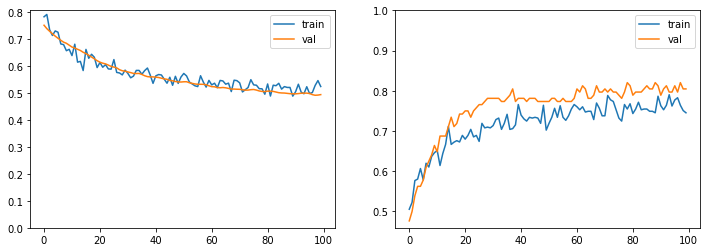

In [50]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 160, 160, 3) float32
(697,) int32
(175, 160, 160, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 29s 287ms/step - loss: 92.7411 - val_loss: 78.6023
Epoch 2/100
100/100 [==============================] - 25s 248ms/step - loss: 83.3890 - val_loss: 76.2397
Epoch 3/100
100/100 [==============================] - 25s 248ms/step - loss: 75.8685 - val_loss: 76.7554
Epoch 4/100
100/100 [==============================] - 25s 248ms/step - loss: 69.6785 - val_loss: 78.5529
Epoch 5/100
100/100 [==============================] - 25s 249ms/step - loss: 63.9456 - val_loss: 78.4401
Epoch 6/100
100/100 [==============================] - 25s 248ms/step - loss: 62.2652 - val_loss: 79.5814
Epoch 7/100
100/100 [==============================] - 25s 248ms/step - loss: 57.0200 - val_loss: 81.0387
Epoch 8/100
100/100 [==============================] - 25s 248ms/step - loss: 54.0505 - val_loss: 79.1141
Epoch 9/100
100/100 [==============================] - 25s 250ms/step - loss: 50.9754 - val_loss: 79.6999
Epoch 10/100
100/100 [========================

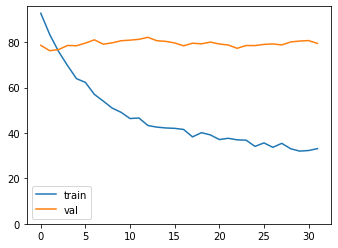

In [51]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
22/22 [==============================] - 7s 322ms/step - loss: 0.7897 - accuracy: 0.5241 - precision: 0.5243 - recall: 0.3717 - f1: 0.4290 - specificity: 0.6754 - negative_predictive_value: 0.5205 - matthews_correlation_coefficient: 0.0463 - equal_error_rate: 0.4918 - val_loss: 0.8197 - val_accuracy: 0.4500 - val_precision: 0.4347 - val_recall: 0.4834 - val_f1: 0.4562 - val_specificity: 0.4025 - val_negative_predictive_value: 0.4495 - val_matthews_correlation_coefficient: -0.1150 - val_equal_error_rate: 0.5139

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.11501, saving model to ../../models/siamese_networks/mouth_open_2020_06_06-07_01_55.h5
Epoch 2/100
22/22 [==============================] - 4s 160ms/step - loss: 0.7855 - accuracy: 0.5130 - precision: 0.5215 - recall: 0.4350 - f1: 0.4677 - specificity: 0.5977 - negative_predictive_value: 0.5114 - matthews_correlation_coefficient: 0.0328 - equal_error_rate: 0.4832 - val_loss: 0.7450 - val_accur

22/22 [==============================] - 3s 155ms/step - loss: 0.7304 - accuracy: 0.5667 - precision: 0.5794 - recall: 0.5509 - f1: 0.5562 - specificity: 0.5876 - negative_predictive_value: 0.5637 - matthews_correlation_coefficient: 0.1407 - equal_error_rate: 0.4539 - val_loss: 0.6600 - val_accuracy: 0.6687 - val_precision: 0.6517 - val_recall: 0.6956 - val_f1: 0.6714 - val_specificity: 0.6435 - val_negative_predictive_value: 0.6838 - val_matthews_correlation_coefficient: 0.3373 - val_equal_error_rate: 0.3450

Epoch 00013: val_matthews_correlation_coefficient improved from 0.32819 to 0.33728, saving model to ../../models/siamese_networks/mouth_open_2020_06_06-07_01_55.h5
Epoch 14/100
22/22 [==============================] - 3s 156ms/step - loss: 0.7074 - accuracy: 0.5768 - precision: 0.5801 - recall: 0.5861 - f1: 0.5794 - specificity: 0.5612 - negative_predictive_value: 0.5674 - matthews_correlation_coefficient: 0.1473 - equal_error_rate: 0.4367 - val_loss: 0.6615 - val_accuracy: 0.675


Epoch 00025: val_matthews_correlation_coefficient did not improve from 0.41755
Epoch 26/100
22/22 [==============================] - 3s 154ms/step - loss: 0.6861 - accuracy: 0.5870 - precision: 0.5861 - recall: 0.5977 - f1: 0.5873 - specificity: 0.5803 - negative_predictive_value: 0.5943 - matthews_correlation_coefficient: 0.1792 - equal_error_rate: 0.3972 - val_loss: 0.6351 - val_accuracy: 0.6875 - val_precision: 0.6953 - val_recall: 0.6578 - val_f1: 0.6704 - val_specificity: 0.7257 - val_negative_predictive_value: 0.6887 - val_matthews_correlation_coefficient: 0.3837 - val_equal_error_rate: 0.2817

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.41755
Epoch 27/100
22/22 [==============================] - 3s 155ms/step - loss: 0.7050 - accuracy: 0.5725 - precision: 0.5772 - recall: 0.5827 - f1: 0.5742 - specificity: 0.5679 - negative_predictive_value: 0.5740 - matthews_correlation_coefficient: 0.1509 - equal_error_rate: 0.4211 - val_loss: 0.6342 - val_accurac

22/22 [==============================] - 3s 152ms/step - loss: 0.6713 - accuracy: 0.5971 - precision: 0.5989 - recall: 0.5742 - f1: 0.5826 - specificity: 0.6121 - negative_predictive_value: 0.5870 - matthews_correlation_coefficient: 0.1860 - equal_error_rate: 0.3937 - val_loss: 0.6205 - val_accuracy: 0.7000 - val_precision: 0.7178 - val_recall: 0.6424 - val_f1: 0.6739 - val_specificity: 0.7607 - val_negative_predictive_value: 0.6899 - val_matthews_correlation_coefficient: 0.4054 - val_equal_error_rate: 0.3251

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.43479
Epoch 40/100
22/22 [==============================] - 3s 151ms/step - loss: 0.6731 - accuracy: 0.5971 - precision: 0.6071 - recall: 0.5649 - f1: 0.5816 - specificity: 0.6221 - negative_predictive_value: 0.5797 - matthews_correlation_coefficient: 0.1869 - equal_error_rate: 0.3864 - val_loss: 0.6209 - val_accuracy: 0.7000 - val_precision: 0.7178 - val_recall: 0.6424 - val_f1: 0.6739 - val_specificity: 0.


Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.43479
Epoch 53/100
22/22 [==============================] - 3s 152ms/step - loss: 0.6620 - accuracy: 0.6043 - precision: 0.6246 - recall: 0.5610 - f1: 0.5849 - specificity: 0.6565 - negative_predictive_value: 0.5973 - matthews_correlation_coefficient: 0.2196 - equal_error_rate: 0.3986 - val_loss: 0.6251 - val_accuracy: 0.7063 - val_precision: 0.7233 - val_recall: 0.6578 - val_f1: 0.6842 - val_specificity: 0.7607 - val_negative_predictive_value: 0.6981 - val_matthews_correlation_coefficient: 0.4199 - val_equal_error_rate: 0.3069

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.43479
Epoch 54/100
22/22 [==============================] - 3s 150ms/step - loss: 0.6738 - accuracy: 0.5855 - precision: 0.6026 - recall: 0.5648 - f1: 0.5776 - specificity: 0.6162 - negative_predictive_value: 0.5790 - matthews_correlation_coefficient: 0.1813 - equal_error_rate: 0.3982 - val_loss: 0.6255 - val_accurac

22/22 [==============================] - 3s 154ms/step - loss: 0.6451 - accuracy: 0.6203 - precision: 0.6264 - recall: 0.5958 - f1: 0.6044 - specificity: 0.6497 - negative_predictive_value: 0.6213 - matthews_correlation_coefficient: 0.2466 - equal_error_rate: 0.3713 - val_loss: 0.6287 - val_accuracy: 0.7063 - val_precision: 0.7157 - val_recall: 0.6849 - val_f1: 0.6931 - val_specificity: 0.7391 - val_negative_predictive_value: 0.7088 - val_matthews_correlation_coefficient: 0.4242 - val_equal_error_rate: 0.2942

Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.43479
Epoch 67/100
22/22 [==============================] - 3s 150ms/step - loss: 0.6468 - accuracy: 0.6362 - precision: 0.6511 - recall: 0.6053 - f1: 0.6212 - specificity: 0.6709 - negative_predictive_value: 0.6286 - matthews_correlation_coefficient: 0.2779 - equal_error_rate: 0.3493 - val_loss: 0.6246 - val_accuracy: 0.6938 - val_precision: 0.6960 - val_recall: 0.6849 - val_f1: 0.6845 - val_specificity: 0.


Epoch 00079: val_matthews_correlation_coefficient did not improve from 0.43479
Epoch 80/100
22/22 [==============================] - 3s 151ms/step - loss: 0.6382 - accuracy: 0.6420 - precision: 0.6602 - recall: 0.5921 - f1: 0.6190 - specificity: 0.6929 - negative_predictive_value: 0.6283 - matthews_correlation_coefficient: 0.2867 - equal_error_rate: 0.3598 - val_loss: 0.6256 - val_accuracy: 0.7063 - val_precision: 0.7180 - val_recall: 0.6696 - val_f1: 0.6880 - val_specificity: 0.7502 - val_negative_predictive_value: 0.7025 - val_matthews_correlation_coefficient: 0.4201 - val_equal_error_rate: 0.2817

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.43479
Epoch 81/100
22/22 [==============================] - 3s 155ms/step - loss: 0.6614 - accuracy: 0.6058 - precision: 0.6089 - recall: 0.5960 - f1: 0.5989 - specificity: 0.6171 - negative_predictive_value: 0.6041 - matthews_correlation_coefficient: 0.2130 - equal_error_rate: 0.3822 - val_loss: 0.6277 - val_accurac

22/22 [==============================] - 3s 151ms/step - loss: 0.6478 - accuracy: 0.6264 - precision: 0.6348 - recall: 0.5916 - f1: 0.6087 - specificity: 0.6625 - negative_predictive_value: 0.6184 - matthews_correlation_coefficient: 0.2536 - equal_error_rate: 0.3686 - val_loss: 0.6182 - val_accuracy: 0.7000 - val_precision: 0.7195 - val_recall: 0.6460 - val_f1: 0.6757 - val_specificity: 0.7607 - val_negative_predictive_value: 0.6909 - val_matthews_correlation_coefficient: 0.4086 - val_equal_error_rate: 0.3195

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.44668
Epoch 94/100
22/22 [==============================] - 3s 151ms/step - loss: 0.6490 - accuracy: 0.6217 - precision: 0.6466 - recall: 0.5810 - f1: 0.6053 - specificity: 0.6716 - negative_predictive_value: 0.6123 - matthews_correlation_coefficient: 0.2557 - equal_error_rate: 0.3830 - val_loss: 0.6140 - val_accuracy: 0.6812 - val_precision: 0.6935 - val_recall: 0.6306 - val_f1: 0.6571 - val_specificity: 0.

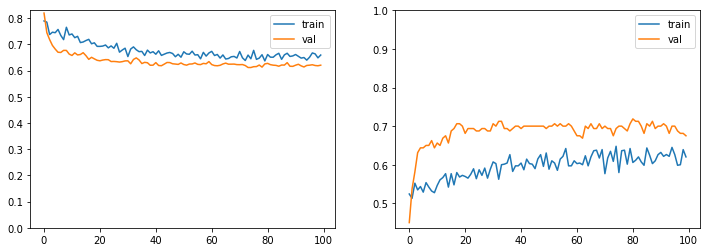

In [52]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 160, 160, 3) float32
(65,) int32
(17, 160, 160, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 17s 167ms/step - loss: 91.0619 - val_loss: 88.9853
Epoch 2/100
100/100 [==============================] - 13s 126ms/step - loss: 75.5588 - val_loss: 80.7461
Epoch 3/100
100/100 [==============================] - 13s 126ms/step - loss: 66.4119 - val_loss: 77.7788
Epoch 4/100
100/100 [==============================] - 13s 127ms/step - loss: 58.4367 - val_loss: 76.9043
Epoch 5/100
100/100 [==============================] - 13s 126ms/step - loss: 50.0959 - val_loss: 72.2821
Epoch 6/100
100/100 [==============================] - 13s 127ms/step - loss: 42.0738 - val_loss: 70.2121
Epoch 7/100
100/100 [==============================] - 13s 127ms/step - loss: 36.8976 - val_loss: 68.7707
Epoch 8/100
100/100 [==============================] - 13s 126ms/step - loss: 32.6122 - val_loss: 70.4803
Epoch 9/100
100/100 [==============================] - 13s 127ms/step - loss: 29.4775 - val_loss: 68.8178
Epoch 10/100
100/100 [========================

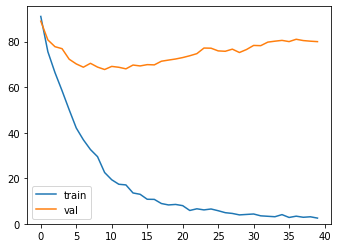

In [53]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(rescale=1 / 255)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 1.0340 - accuracy: 0.5729 - precision: 1.0000 - recall: 0.1695 - f1: 0.2869 - specificity: 1.0000 - negative_predictive_value: 0.5349 - matthews_correlation_coefficient: 0.3001 - equal_error_rate: 0.3861 - val_loss: 0.7501 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.6458

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.43644, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_06-07_19_34.h5
Epoch 2/100
3/3 [==============================] - 0s 123ms/step - loss: 0.7617 - accuracy: 0.6000 - precision: 0.6111 - recall: 0.1439 - f1: 0.2278 - specificity: 0.8929 - negative_predictive_value: 0.5778 - matthews_correlation_coefficient: 0.0861 - equal_error_rate: 0.3229 - val_loss: 0.7433

3/3 [==============================] - 0s 126ms/step - loss: 0.8366 - accuracy: 0.5857 - precision: 0.6389 - recall: 0.3177 - f1: 0.3954 - specificity: 0.8515 - negative_predictive_value: 0.6181 - matthews_correlation_coefficient: 0.2051 - equal_error_rate: 0.4784 - val_loss: 0.6982 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.4653

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 15/100
3/3 [==============================] - 0s 141ms/step - loss: 0.5117 - accuracy: 0.6857 - precision: 0.9048 - recall: 0.4316 - f1: 0.5822 - specificity: 0.9586 - negative_predictive_value: 0.6800 - matthews_correlation_coefficient: 0.4775 - equal_error_rate: 0.2816 - val_loss: 0.6979 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 28/100
3/3 [==============================] - 0s 126ms/step - loss: 0.7630 - accuracy: 0.6429 - precision: 0.6190 - recall: 0.2963 - f1: 0.3981 - specificity: 0.8095 - negative_predictive_value: 0.5521 - matthews_correlation_coefficient: 0.1363 - equal_error_rate: 0.5192 - val_loss: 0.7072 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.4653

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 29/100
3/3 [==============================] - 0s 129ms/step - loss: 0.8377 - accuracy: 0.6042 - precision: 0.7593 - recall: 0.3319 - f1: 0.4594 - specificity: 0.8872 - negative_predictive_value: 0.5585 - matthews_correlation_coefficient: 0.2634 - equal_error_rate: 0.4381 - val_loss: 0.7080 - val_accuracy: 0

3/3 [==============================] - 0s 122ms/step - loss: 0.6840 - accuracy: 0.6042 - precision: 0.7108 - recall: 0.3362 - f1: 0.4513 - specificity: 0.8697 - negative_predictive_value: 0.5604 - matthews_correlation_coefficient: 0.2349 - equal_error_rate: 0.3019 - val_loss: 0.7493 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.4364 - val_equal_error_rate: 0.4653

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.43644
Epoch 42/100
3/3 [==============================] - 0s 125ms/step - loss: 0.7341 - accuracy: 0.6143 - precision: 0.8333 - recall: 0.3618 - f1: 0.4941 - specificity: 0.9298 - negative_predictive_value: 0.6478 - matthews_correlation_coefficient: 0.3741 - equal_error_rate: 0.4180 - val_loss: 0.7543 - val_accuracy: 0.6471 - val_precision: 1.0000 - val_recall: 0.3333 - val_f1: 0.5000 - val_specificity: 1.0000

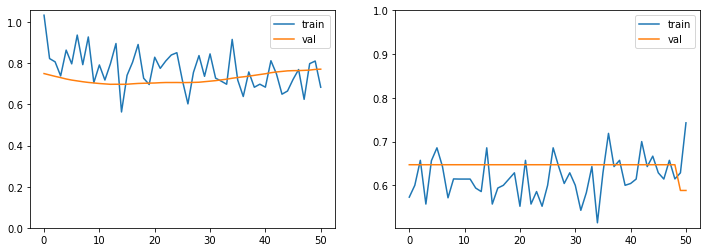

In [54]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

In [58]:
print(len(list_model_files))
print(np.array(list_model_files))

21
['../../models/siamese_networks/blurred_2020_06_05-22_35_23.h5'
 '../../models/siamese_networks/looking_away_2020_06_05-23_01_19.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_05-23_11_12.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_05-23_42_00.h5'
 '../../models/siamese_networks/washed_out_2020_06_05-23_57_49.h5'
 '../../models/siamese_networks/pixelation_2020_06_06-00_08_48.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_06-00_47_34.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_06-00_59_29.h5'
 '../../models/siamese_networks/varied_background_2020_06_06-01_39_05.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_06-01_59_37.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_06-02_11_54.h5'
 '../../models/siamese_networks/red_eyes_2020_06_06-02_40_54.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_06-03_18_05.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_06-03_59_38.h5'

# Models Merge

In [79]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:]]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [64]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256

In [86]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [89]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [91]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.5475294]], dtype=float32),
 array([[0.34461638]], dtype=float32),
 array([[0.8842254]], dtype=float32),
 array([[0.0118573]], dtype=float32),
 array([[0.23932184]], dtype=float32),
 array([[0.67812157]], dtype=float32),
 array([[0.2995494]], dtype=float32),
 array([[0.30914807]], dtype=float32),
 array([[0.15944973]], dtype=float32),
 array([[0.44696134]], dtype=float32),
 array([[0.57636297]], dtype=float32),
 array([[0.24243854]], dtype=float32),
 array([[0.10406008]], dtype=float32),
 array([[0.6966467]], dtype=float32),
 array([[0.675111]], dtype=float32),
 array([[0.51778305]], dtype=float32),
 array([[0.6754373]], dtype=float32),
 array([[0.8821479]], dtype=float32),
 array([[0.69937223]], dtype=float32),
 array([[0.46977326]], dtype=float32),
 array([[0.4626636]], dtype=float32)]